In [1]:
####################################################################################
#
# Compare_Methodologies.ipynb - script for comparing patch and schema files for Joomla, Roundcube, and Weberp projects
# Copyright (C) 2023  Sravani Namburi
#
# Compare_Methodologies.ipynb program is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 3 of the License, or
# (at your option) any later version.
# 
# Compare_Methodologies.ipynb program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# 
# You should have received a copy of the GNU General Public License along
# with Compare_Methodologies.ipynb program; If not, see <https://www.gnu.org/licenses/>.
#
####################################################################################

In [2]:
import os
import io
import csv
import shutil
import git
import re
import pandas as pd
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from colorama import Fore, Style

### Process Patch Files for webERP and Roundcube Projects

In [3]:
#!/usr/bin/env python

# Process the patch files and extract the count of DDL statements, saving the results in CSV files

#Repository clone
GITHUB_URL_Weberp = 'https://github.com/webERP-team/webERP.git'
FOLDER_PATH_Weberp = 'Datasets/Weberp/Input/Patch_Files/Git_WebERP'

GITHUB_URL_Roundcube = 'https://github.com/roundcube/roundcubemail.git'
FOLDER_PATH_Roundcube = 'Datasets/Roundcube/Input/Patch_Files/Git_Roundcube'

def get_repo_weberp():
    if not os.path.exists(os.path.join(os.getcwd(), FOLDER_PATH_Weberp)):
        print("Weberp Repository cloning...")
        repo = git.Repo.clone_from(GITHUB_URL_Weberp, FOLDER_PATH_Weberp)
        print("Repo cloned.")
    else:
        repo = git.Repo(FOLDER_PATH_Weberp)
        print("Existing Weberp repo used.")
    return repo

def get_repo_roundcube():

    if not os.path.exists(os.path.join(os.getcwd(), FOLDER_PATH_Roundcube)):
        print("Roundcube Repository cloning...")
        repo = git.Repo.clone_from(GITHUB_URL_Roundcube, FOLDER_PATH_Roundcube)
        print("Repo cloned.")
    else:
        repo = git.Repo(FOLDER_PATH_Roundcube)
        print("Existing Roundcube repo used.")
    return repo

def project_arguments(projects=None):
    if projects is None:
        projects = ["Weberp", "Roundcube"]
    return {"projects": projects}

#Extract version  
def get_version(filename):
    return filename.strip()[:-4]

#select Sql patters 
def sql_query():
    cmp_dct = dict()
    cmp_dct["Version"] = 0
    cmp_dct["File_Path"] = 0
    cmp_dct["Create_Table"] = 0  
    cmp_dct["Drop_Table"] = 0  
    cmp_dct["Add_Column"] = 0  
    cmp_dct["Drop_Column"] = 0  
    cmp_dct["Change_Column_Datatype"] = 0 
    cmp_dct["Rename_Table"] = 0  
    cmp_dct["Rename_Column"] = 0  
    return cmp_dct

#parse the sql statements
def sql_parse_output(cmp_dct, output):
    lines = output.split("\n")

    for line in lines:
        if "CREATE TABLE" in line.upper():
            cmp_dct["Create_Table"] += 1
            
        if "DROP TABLE" in line.upper():
            if "DROP TABLE IF EXISTS" not in line:
                cmp_dct["Drop_Table"] += 1

        if line.find("ADD") != -1:
            if "ADD INDEX" not in line and "ADD KEY" not in line and "ADD UNIQUE" not in line \
            and "ADD PRIMARY KEY" not in line and "ADD FOREIGN KEY" not in line \
            and "ADD  FOREIGN  KEY" not in line and "ADD CONSTRAINT" not in line and "ADD  CONSTRAINT" not in line:
                cmp_dct["Add_Column"] += line.count("ADD")  ## multiple ADD keywords in line
                 
                
        else:
            if line.find("add ") != -1:
                if "INDEX" not in line and "KEY" not in line and "UNIQUE" not in line \
                and "PRIMARY KEY" not in line and "FOREIGN KEY" not in line and "CONSTRAINT" not in line:
                    cmp_dct["Add_Column"] += 1
                    
        if "ALTER TABLE" in line and "ADD" in line and "," in line and "ADD INDEX" in line and "DROP INDEX" not in line and \
            "`," not in line:
            cmp_dct["Add_Column"] += 1
                   
        if "DROP" in line.upper().split():
            if "DROP TABLE" not in line.upper() and "DROP INDEX" not in line.upper() \
            and "DROP KEY" not in line.upper() and "DROP UNIQUE" not in line.upper() and "DROP PRIMARY KEY" not in line.upper() \
            and "DROP FOREIGN KEY" not in line.upper() and "DROP CONSTRAINT" not in line.upper() and "DROP DEFAULT" not in line.upper():
                cmp_dct["Drop_Column"] += 1
            elif "DROP DEFAULT" in line.upper():
                cmp_dct["Change_Column_Datatype"] += 1
             
        if "MODIFY" in line.upper().split():
            cmp_dct["Change_Column_Datatype"] += 1
          
        if "RENAME" in line.upper().split():
            cmp_dct["Rename_Table"] += 1
          
        if line.find("CHANGE") != -1:
            if "CHANGE COLUMN" not in line:
                columns = line.replace("  ", " ").split("CHANGE ")[1].split(" ")
                col1 = columns[0].strip("`")  
                col2 = columns[1].strip("`")  
                if col1 != col2:
                    cmp_dct["Rename_Column"] += 1
                else:
                    cmp_dct["Change_Column_Datatype"] += 1
                  
                    
        else:
            if "change" in line.split():
                columns = line.split("change ")[1].split(" ")
                col1 = columns[0].strip("`")  
                col2 = columns[1].strip("`")  
                if col1 != col2:
                    cmp_dct["Rename_Column"] += 1
                else:
                    cmp_dct["Change_Column_Datatype"] += 1
                   

        if line.find("CHANGE COLUMN")  != -1:
            columns = line.split("CHANGE COLUMN ")[1].split(" ") 
            col1 = columns[0].strip("`")  
            col2 = columns[1].strip("`")  
            if col1 != col2:
                cmp_dct["Rename_Column"] += 1
            else:
                cmp_dct["Change_Column_Datatype"] += 1   
                  
                
    return cmp_dct        


def list_sql(File):
    with open(File, 'r', encoding='utf8') as f:
        lines = f.readlines()
        sql_script = ' '.join([line for line in lines if not line.strip().startswith('INSERT') and \
                               not line.strip().startswith('--') and not line.strip().startswith('#') and \
                               not line.strip().startswith('##') and not line.upper().strip().startswith('INSERT') and \
                               not line.upper().strip().startswith('UPDATE') and not line.strip().startswith('VALUES') and \
                               not line.strip().startswith('(')])
        
    return sql_script

    
def Weberp():
    os.chdir("..") 
    repo = get_repo_weberp()  
    repo.git.execute(['git', 'checkout', 'master'])

    sql_files=repo.git.execute(['git', 'ls-files','''*.sql'''])
    file_paths= [os.path.join("Datasets/Weberp/Input/Patch_Files/Git_WebERP",path_string) for path_string in sql_files.split('\n')]   
    file_basenames = [os.path.basename(path_string) for path_string in file_paths]
    
    sql_files1 = [f for f in repo.git.ls_files().split('\n') if f.endswith('.sql')]

    # Count the number of commits that have modified each .sql file
    rows = []
    for File in sql_files1:
        try:
            commits = list(repo.iter_commits(paths=File))
            rows.append((File, File.split('/')[-1].replace('.sql',''), len(commits)))
        except Exception as e:
            print(f"Error counting commits for file {File}: {str(e)}")

    with open('{}/Datasets/Weberp/Output/Weberp_Commit_Count.csv'.format(os.getcwd()), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['File_Path', 'File', 'Commit_Count'])
        writer.writerows(rows)

    # log file for each SQL file
    with open("{}/Datasets/Weberp/Output/Weberp_SQLFile_log_Info.txt".format(os.getcwd()), 'w') as f:
        for file_path in sql_files.split('\n'):
            # Get the git log for sql files
            log = repo.git.log(file_path)
            f.write(f'Git log for file {file_path}:\n{log}\n\n')

    # Extract SQL schema changes   
    def schema_changes():
        results_dict = {"File_Path": [], "Version": [], "Create_Table": [], "Drop_Table": [], "Add_Column": [], "Drop_Column": [], "Change_Column_Datatype": [],"Rename_Table": [],"Rename_Column": []}
        for each_file, each_file_path in zip(file_basenames, file_paths):
            cmp_dct=sql_query()
            if not each_file.startswith("upgrade"):
                continue
                
            #we need to skip this files from patch, because DSF files start from verion 3.0 (commit history). 
            if each_file.startswith("upgrade2.7-2.8.sql"):
                continue
            if each_file.startswith("upgrade2.8-2.9.sql"):
                continue
            if each_file.startswith("upgrade2.9-2.9a.sql"):
                continue  
            if each_file.startswith("upgrade2.9a-2.9b.sql"):
                continue                
                
            version = get_version(each_file)
            cmp_dct['Version'] = version
            
            Filepath = each_file_path.strip().replace('Git_WebERP\\','')
            cmp_dct['File_Path'] = Filepath
            
            results_cmp_dct = sql_parse_output(cmp_dct,list_sql(each_file_path))
            for key,value in results_cmp_dct.items():
                results_dict[key].append(value)
               
        df = pd.DataFrame(results_dict)
        df.loc[:,'SMOs_Total'] = df.sum(numeric_only=True, axis=1)
        df.to_csv("{}/Datasets/Weberp/Output/Weberp_MySQL_Patch_Files.csv".format(os.getcwd()),index=False)
        
    schema_changes()
    os.chdir('Code')
    
def Roundcube():
    os.chdir("..")
    repo = get_repo_roundcube()  
    repo.git.execute(['git', 'checkout', 'master'])
    sql_files=repo.git.execute(['git', 'ls-files','''*.sql'''])
    file_paths= [os.path.join("Datasets/Roundcube/Input/Patch_Files/Git_Roundcube",path_string) for path_string in sql_files.split('\n')]   
    file_basenames = [os.path.basename(path_string) for path_string in file_paths]
    
    sql_files1 = [f for f in repo.git.ls_files().split('\n') if f.endswith('.sql')]

    # Count the number of commits that have modified each .sql file
    rows = []
    for File in sql_files1:
        try:
            commits = list(repo.iter_commits(paths=File))
            if 'SQL/mysql' not in File:
                continue 
            rows.append((File, File.split('/')[-1].replace('.sql',''), len(commits)))
        except Exception as e:
            print(f"Error counting commits for file {File}: {str(e)}")

    with open('{}/Datasets/Roundcube/Output/Roundcube_Commit_Count.csv'.format(os.getcwd()), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['File_Path', 'File', 'Commit_Count'])
        writer.writerows(rows)

    # log file for each SQL file
    with open("{}/Datasets/Roundcube/Output/Roundcube_SQLFile_log_Info.txt".format(os.getcwd()), 'w') as f:
        for file_path in sql_files.split('\n'):
             if 'mysql' in file_path and 'tests' in file_path:
                 continue
             log = repo.git.log(file_path)
             f.write(f'Git log for file {file_path}:\n{log}\n\n')

    # Extract SQL schema changes
    def schema_changes():
        findings = []
        results_dict = {"File_Path": [], "Version": [], "Create_Table": [], "Drop_Table": [], "Add_Column": [], "Drop_Column": [], "Change_Column_Datatype": [],"Rename_Table": [],"Rename_Column": []}
        for each_file, each_file_path in zip(file_basenames, file_paths):
            cmp_dct=sql_query()
 
            if 'SQL/mysql' not in each_file_path:
                continue   

            if  each_file.startswith("mysql.initial.sql"):
                continue

            version = get_version(each_file)
            cmp_dct['Version'] = version
            
            Filepath = each_file_path.strip().replace('Git_Roundcube\\','')
            cmp_dct['File_Path'] = Filepath

            results_cmp_dct = sql_parse_output(cmp_dct,list_sql(each_file_path))
            for key,value in results_cmp_dct.items():
                results_dict[key].append(value)
              
        df = pd.DataFrame(results_dict)
        df.loc[:,'SMOs_Total'] = df.sum(numeric_only=True, axis=1)
        df.to_csv("{}/Datasets/Roundcube/Output/Roundcube_MySQL_Patch_Files.csv".format(os.getcwd()),index=False)
        
    schema_changes()  
    os.chdir('Code')

    
def main():
    projects = ["Weberp", "Roundcube"]

    for project in projects:
        if project == "Weberp":
            Weberp()
        elif project == "Roundcube":
            Roundcube()  

                   
if __name__ == "__main__":
   main()

Existing Weberp repo used.
Existing Roundcube repo used.


### Process Patch Files for Joomla Project

In [4]:
#!/usr/bin/env python

# Process the patch files and extract the count of DDL statements, saving the results in CSV files
# Note:
#We analyzed the 4.2-dev branch, but it has been merged into the 4.4-dev branch. Currently, the 4.2-dev branch 
#is not available in the GitHub repository. Therefore, we cloned the 4.4-dev branch and excluded
#the files specific to versions 4.4 and 4.3. We then proceeded to analyze only the files from the 4.2-dev version.


#Repository clone

GITHUB_URL_Joomla = 'https://github.com/joomla/joomla-cms.git'
FOLDER_PATH_Joomla = 'Datasets/Joomla/Input/Patch_Files/Git_Joomla'


def get_repo_joomla():

    if not os.path.exists(os.path.join(os.getcwd(), FOLDER_PATH_Joomla)):
        print("Joomla Repository cloning...")
        repo = git.Repo.clone_from(GITHUB_URL_Joomla, FOLDER_PATH_Joomla)
        print("Repo cloned.")
    else:
        repo = git.Repo(FOLDER_PATH_Joomla)
        print("Existing Joomla repo used.")
    return repo



#Extract version

def get_version(filename):
    return filename.strip()[:-4]

#select Sql patters 
def sql_query():

    cmp_dct = dict()
    cmp_dct["Version"] = 0
    cmp_dct["File_Path"] = 0
    cmp_dct["Create_Table"] = 0  
    cmp_dct["Drop_Table"] = 0  
    cmp_dct["Add_Column"] = 0  
    cmp_dct["Drop_Column"] = 0  
    cmp_dct["Change_Column_Datatype"] = 0 
    cmp_dct["Rename_Table"] = 0  
    cmp_dct["Rename_Column"] = 0  
    return cmp_dct

#parse the sql statements
def sql_parse_output(cmp_dct, output):
    lines = output.split("\n")

    for line in lines:
        if "CREATE TABLE" in line.upper():
            cmp_dct["Create_Table"] += 1
        
        if "DROP TABLE" in line.upper():
            cmp_dct["Drop_Table"] += 1
           
        if line.find("ADD") != -1:
            if "ADD INDEX" not in line and "ADD KEY" not in line and "ADD UNIQUE" not in line and "changelogurl" not in line \
            and "ADD PRIMARY KEY" not in line and "ADD FOREIGN KEY" not in line \
            and "ADD  FOREIGN  KEY" not in line and "ADD CONSTRAINT" not in line and "ADD  CONSTRAINT" not in line:
                cmp_dct["Add_Column"] += line.count("ADD") 
              
        else:
            if line.find("add ") != -1:
                if "INDEX" not in line and "KEY" not in line and "UNIQUE" not in line \
                and "PRIMARY KEY" not in line and "FOREIGN KEY" not in line and "CONSTRAINT" not in line:
                    cmp_dct["Add_Column"] += 1
                   
        if "DROP" in line.upper().split():
            if "DROP TABLE" not in line.upper() and "DROP INDEX" not in line.upper() and "system_data" not in line and "invalid" not in line \
            and "DROP KEY" not in line.upper() and "DROP UNIQUE" not in line.upper() and "DROP PRIMARY KEY" not in line.upper() \
            and "DROP FOREIGN KEY" not in line.upper() and "DROP CONSTRAINT" not in line.upper() and "DROP DEFAULT" not in line.upper():
                cmp_dct["Drop_Column"] += 1
             
        if "MODIFY" in line.upper().split(): 
            cmp_dct["Change_Column_Datatype"] += 1
          
        if "RENAME" in line.upper().split():
            cmp_dct["Rename_Table"] += 1
          
        if line.find("CHANGE") != -1:
            if "CHANGE COLUMN" not in line:
                columns = line.replace("  ", " ").split("CHANGE ")[1].split(" ")
                col1 = columns[0].strip("`")  
                col2 = columns[1].strip("`")  
                if col1 != col2:
                    cmp_dct["Rename_Column"] += 1
                else:
                    cmp_dct["Change_Column_Datatype"] += 1
                  
                    
        else:
            if "change" in line.split():
                columns = line.split("change ")[1].split(" ")
                col1 = columns[0].strip("`")  
                col2 = columns[1].strip("`")  
                if col1 != col2:
                    cmp_dct["Rename_Column"] += 1
                else:
                    cmp_dct["Change_Column_Datatype"] += 1
                   

        if line.find("CHANGE COLUMN")  != -1:
            columns = line.split("CHANGE COLUMN ")[1].split(" ") 
            col1 = columns[0].strip("`")  
            col2 = columns[1].strip("`")  
            if col1 != col2:
                cmp_dct["Rename_Column"] += 1
            else:
                cmp_dct["Change_Column_Datatype"] += 1   
              
                
    return cmp_dct        


def list_sql(File):
    with open(File, 'r', encoding='utf8') as f:
        lines = f.readlines()
        sql_script = ' '.join([line for line in lines if not line.strip().startswith('INSERT') and \
                               not line.strip().startswith('--') and not line.strip().startswith('#') and \
                               not line.strip().startswith('##') and not line.upper().strip().startswith('INSERT') and \
                               not line.upper().strip().startswith('UPDATE') and not line.strip().startswith('VALUES') and \
                               not line.strip().startswith('(')])
        
    return sql_script

    
def Joomla():
    os.chdir("..")
    
    repo = get_repo_joomla()  
    repo.git.execute(['git', 'checkout', '4.4-dev'])
  
    sql_files=repo.git.execute(['git', 'ls-files','''*.sql'''])
    file_paths= [os.path.join("Datasets/Joomla/Input/Patch_Files/Git_Joomla",path_string) for path_string in sql_files.split('\n')]   
    file_basenames = [os.path.basename(path_string) for path_string in file_paths]

    sql_files1 = [f for f in repo.git.ls_files().split('\n') if f.endswith('.sql')]

    # Count the number of commits that have modified each .sql file
    rows = []
    for File in sql_files1:
        try:
            commits = list(repo.iter_commits(paths=File))
            if 'updates/mysql' not in File:
                continue
            rows.append((File, File.split('/')[-1].replace('.sql',''), len(commits)))
        except Exception as e:
            print(f"Error counting commits for file {File}: {str(e)}")
            
    with open('{}/Datasets/Joomla/Output/Joomla_Commit_Count.csv'.format(os.getcwd()), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['File_Path', 'File', 'Commit_Count'])
        writer.writerows(rows)

    # log file for each SQL file
    with open("{}/Datasets/Joomla/Output/Joomla_SQLFile_log_Info.txt".format(os.getcwd()), 'w') as f:
        for file_path in sql_files.split('\n'):
            if 'updates/mysql' not in file_path:
                continue
            log = repo.git.log(file_path)
            f.write(f'Git log for file {file_path}:\n{log}\n\n')
    
    # Extract SQL schema changes
    def schema_changes():
        findings = []
        results_dict = {"File_Path": [], "Version": [], "Create_Table": [], "Drop_Table": [], "Add_Column": [], "Drop_Column": [], "Change_Column_Datatype": [],"Rename_Table": [],"Rename_Column": []}
        for each_file, each_file_path in zip(file_basenames, file_paths):
            cmp_dct=sql_query()
            if not each_file.startswith("4"):
                continue
            if each_file.startswith("4.3"):  #skipping 4.3 version files.
                continue
            if each_file.startswith("4.4"):  #skipping 4.4 version files.
                continue
                
            if 'updates/mysql' not in each_file_path:
                continue
            version = get_version(each_file)
            cmp_dct['Version'] = version
            
            Filepath = each_file_path.strip().replace('Git_Joomla\\','')
            cmp_dct['File_Path'] = Filepath

            #output schema changes 
            results_cmp_dct = sql_parse_output(cmp_dct,list_sql(each_file_path))
            for key,value in results_cmp_dct.items():
                results_dict[key].append(value)

        df = pd.DataFrame(results_dict)
        df.loc[:,'SMOs_Total'] = df.sum(numeric_only=True, axis=1)
        df.to_csv("{}/Datasets/Joomla/Output/Joomla_MySQL_Patch_Files.csv".format(os.getcwd()),index=False)
        
    schema_changes()
    os.chdir('Code')
  
def main():
    Joomla()

                   
if __name__ == "__main__":
   main()

Existing Joomla repo used.


In [5]:
# Merge the two dataframes (patch files' SMOs and commit counts) for three datasets

os.chdir('..')
Weberp_Patch = pd.read_csv('{}/Datasets/WebERP/Output/Weberp_MySQL_Patch_Files.csv'.format(os.getcwd()))
Commit_Count = pd.read_csv('{}/Datasets/WebERP/Output/Weberp_commit_count.csv'.format(os.getcwd()))
Commit_Count = Commit_Count[['File', 'Commit_Count']]
Weberp_Merged = Weberp_Patch.merge(Commit_Count, left_on='Version', right_on='File', how='left')
Weberp_Merged.drop(['File'], axis=1, inplace=True)
Weberp_Merged.to_csv('{}/Datasets/WebERP/Output/Weberp_SMOs_and_Commit_Count.csv'.format(os.getcwd()), index=False)

Joomla_PatchFile = pd.read_csv('{}/Datasets/Joomla/Output/Joomla_MySQL_Patch_Files.csv'.format(os.getcwd()))
Commit_Count = pd.read_csv('{}/Datasets/Joomla/Output/Joomla_Commit_Count.csv'.format(os.getcwd()))
Commit_Count = Commit_Count[['File', 'Commit_Count']]
Joomla_Merged = Joomla_PatchFile.merge(Commit_Count, left_on='Version', right_on='File', how='left')
Joomla_Merged.drop(['File'], axis=1, inplace=True)
Joomla_Merged.to_csv('{}/Datasets/Joomla/Output/Joomla_SMOs_and_Commit_Count.csv'.format(os.getcwd()), index=False)

Roundcube_PatchFile = pd.read_csv('{}/Datasets/Roundcube/Output/Roundcube_MySQL_Patch_Files.csv'.format(os.getcwd()))
Commit_Count = pd.read_csv('{}/Datasets/Roundcube/Output/Roundcube_Commit_Count.csv'.format(os.getcwd()))
Commit_Count = Commit_Count[['File', 'Commit_Count']]
Roundcube_PatchFile['Version'] = Roundcube_PatchFile['Version'].astype(str)
Commit_Count['File'] = Commit_Count['File'].astype(str)
Roundcube_Merged = Roundcube_PatchFile.merge(Commit_Count, left_on='Version', right_on='File', how='left')
Roundcube_Merged.drop(['File'], axis=1, inplace=True)
Roundcube_Merged.to_csv('{}/Datasets/Roundcube/Output/Roundcube_SMOs_and_Commit_Count.csv'.format(os.getcwd()), index=False)
os.chdir('Code')

In [6]:
# Add a new column for the project name

os.chdir('..')
if 'Project_Name' not in Weberp_Merged.columns:
    Weberp_Merged.insert(0, 'Project_Name', 'webERP')
Weberp_Merged['Project_Name'] = Weberp_Merged['Project_Name'].fillna('webERP')
Weberp_Merged.to_csv('{}/Datasets/WebERP/Output/Weberp_SMOs_and_Commit_Count.csv'.format(os.getcwd()), index=False)

if 'project_name' not in Joomla_Merged.columns:
    Joomla_Merged.insert(0, 'Project_Name', 'Joomla')
Joomla_Merged['Project_Name'] = Joomla_Merged['Project_Name'].fillna('Joomla')
Joomla_Merged.to_csv('{}/Datasets/Joomla/Output/Joomla_SMOs_and_Commit_Count.csv'.format(os.getcwd()), index=False)

if 'Project_Name' not in Roundcube_Merged.columns:
    Roundcube_Merged.insert(0, 'Project_Name', 'Roundcube')
Roundcube_Merged['Project_Name'] = Roundcube_Merged['Project_Name'].fillna('Roundcube')
Roundcube_Merged.to_csv('{}/Datasets/Roundcube/Output/Roundcube_SMOs_and_Commit_Count.csv'.format(os.getcwd()), index=False)
os.chdir('Code')

In [7]:
Weberp_Merged

,Project_Name,File_Path,Version,Create_Table,Drop_Table,Add_Column,Drop_Column,Change_Column_Datatype,Rename_Table,Rename_Column,SMOs_Total,Commit_Count
0,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.00-3.01,0,0,0,0,1,0,0,1,13
1,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.01-3.02,7,0,2,1,0,1,6,17,4
2,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.02-3.03,0,0,20,0,6,0,4,30,7
3,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.03-3.04,0,0,0,2,1,0,0,3,7
4,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.04-3.05,3,0,1,0,0,0,0,4,20
5,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.05-3.06,3,1,3,0,1,0,0,8,13
6,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.06-3.07,2,0,0,0,0,0,0,2,3
7,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.07-3.08,0,0,3,0,0,0,0,3,3
8,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.08-3.09,3,0,6,0,2,0,0,11,19
9,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.09-3.10,7,0,9,3,3,0,0,22,22


In [8]:
Joomla_Merged

,Project_Name,File_Path,Version,Create_Table,Drop_Table,Add_Column,Drop_Column,Change_Column_Datatype,Rename_Table,Rename_Column,SMOs_Total,Commit_Count
0,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-03-05,0,0,0,0,1,0,0,1,7
1,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-05-15,4,0,0,0,0,0,0,4,36
2,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-07-19,1,0,0,0,1,0,0,2,10
3,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-07-29,4,18,0,1,28,0,0,51,15
4,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-08-29,0,0,0,0,8,0,0,8,6
5,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-03-09,1,0,0,0,0,0,0,1,8
6,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-03-30,0,0,2,0,1,0,0,3,5
7,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-04-15,0,0,0,0,0,0,0,0,4
8,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-04-22,0,0,0,0,5,0,0,5,5
9,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-05-20,0,0,1,0,0,0,0,1,5


In [9]:
Roundcube_Merged

,Project_Name,File_Path,Version,Create_Table,Drop_Table,Add_Column,Drop_Column,Change_Column_Datatype,Rename_Table,Rename_Column,SMOs_Total,Commit_Count
0,Roundcube,Datasets/Roundcube/Input/Patch_Files/SQL/mysql...,2008030300,0,0,0,0,0,0,0,0,1
1,Roundcube,Datasets/Roundcube/Input/Patch_Files/SQL/mysql...,2008040500,0,0,0,0,6,0,0,6,1
2,Roundcube,Datasets/Roundcube/Input/Patch_Files/SQL/mysql...,2008060900,0,0,0,0,0,0,0,0,1
3,Roundcube,Datasets/Roundcube/Input/Patch_Files/SQL/mysql...,2008092100,0,0,0,1,1,0,0,2,1
4,Roundcube,Datasets/Roundcube/Input/Patch_Files/SQL/mysql...,2009090400,0,0,0,0,1,0,0,1,1
5,Roundcube,Datasets/Roundcube/Input/Patch_Files/SQL/mysql...,2009103100,2,0,1,0,0,0,0,3,1
6,Roundcube,Datasets/Roundcube/Input/Patch_Files/SQL/mysql...,2010042300,0,0,0,0,1,0,0,1,1
7,Roundcube,Datasets/Roundcube/Input/Patch_Files/SQL/mysql...,2010100600,0,0,0,0,1,0,0,1,1
8,Roundcube,Datasets/Roundcube/Input/Patch_Files/SQL/mysql...,2011011200,0,0,1,0,1,0,0,2,1
9,Roundcube,Datasets/Roundcube/Input/Patch_Files/SQL/mysql...,2011092800,5,1,0,0,2,0,0,8,1


In [10]:
# Drop duplicate columns in merged dataframes

Weberp_Patch_Sum = Weberp_Merged.drop(['File_Path', 'Version'], axis=1).sum()
Weberp_df = pd.DataFrame([Weberp_Patch_Sum])
Weberp_df['Project'] = ['webERP']
Weberp_Patch_df = Weberp_df[['Project', 'Create_Table', 'Drop_Table',  'Add_Column',  'Drop_Column', 'Change_Column_Datatype',  'Rename_Table',  'Rename_Column',  'SMOs_Total', 'Commit_Count']]
print(Weberp_Patch_df)

Joomla_Patch = Joomla_Merged.drop(['File_Path', 'Version'], axis=1).sum()
Joomla_Patch_df = pd.DataFrame([Joomla_Patch])
Joomla_Patch_df['Project'] = ['joomla']
Joomla_Patch_df = Joomla_Patch_df[['Project', 'Create_Table', 'Drop_Table',  'Add_Column',  'Drop_Column', 'Change_Column_Datatype',  'Rename_Table',  'Rename_Column',  'SMOs_Total', 'Commit_Count']]
print(Joomla_Patch_df)

Roundcube_Patch = Roundcube_Merged.drop(['File_Path', 'Version'], axis=1).sum()
Roundcube_Patch_df = pd.DataFrame([Roundcube_Patch])
Roundcube_Patch_df['Project'] = ['Roundcube']
Roundcube_Patch_df = Roundcube_Patch_df[['Project', 'Create_Table', 'Drop_Table',  'Add_Column',  'Drop_Column', 'Change_Column_Datatype',  'Rename_Table',  'Rename_Column',  'SMOs_Total', 'Commit_Count']]
print(Roundcube_Patch_df)

  Project  Create_Table  Drop_Table  Add_Column  Drop_Column  \
0  webERP            92           5         187           19   

   Change_Column_Datatype  Rename_Table  Rename_Column  SMOs_Total  \
0                     162             1             15         481   

   Commit_Count  
0           405  
  Project  Create_Table  Drop_Table  Add_Column  Drop_Column  \
0  joomla            13          19          10            5   

   Change_Column_Datatype  Rename_Table  Rename_Column  SMOs_Total  \
0                     122             1              1         171   

   Commit_Count  
0           204  
     Project  Create_Table  Drop_Table  Add_Column  Drop_Column  \
0  Roundcube            15           3          11            7   

   Change_Column_Datatype  Rename_Table  Rename_Column  SMOs_Total  \
0                      37             0              0          73   

   Commit_Count  
0            46  


In [11]:
# Calculate the sum of each metric
Weberp_Patch_df = Weberp_Patch_df.drop(['Project'], axis=1).sum()
Joomla_Patch_df = Joomla_Patch_df.drop(['Project'], axis=1).sum().astype(int)
Roundcube_Patch_df = Roundcube_Patch_df.drop(['Project'], axis=1).sum()

print("\033[1mWeberp:\033[0m")  # \033[1m sets bold text
print(Weberp_Patch_df)
print("\033[1mJoomla:\033[0m")  
print(Joomla_Patch_df)
print("\033[1mRoundcube:\033[0m")  
print(Roundcube_Patch_df)

Weberp:
Create_Table               92
Drop_Table                  5
Add_Column                187
Drop_Column                19
Change_Column_Datatype    162
Rename_Table                1
Rename_Column              15
SMOs_Total                481
Commit_Count              405
dtype: int64
Joomla:
Create_Table               13
Drop_Table                 19
Add_Column                 10
Drop_Column                 5
Change_Column_Datatype    122
Rename_Table                1
Rename_Column               1
SMOs_Total                171
Commit_Count              204
dtype: int32
Roundcube:
Create_Table              15
Drop_Table                 3
Add_Column                11
Drop_Column                7
Change_Column_Datatype    37
Rename_Table               0
Rename_Column              0
SMOs_Total                73
Commit_Count              46
dtype: int64


### Process Database Schema Files

In [12]:
# Process the database migration files for three datasets, and count the DDL statements, save the output in a CSV file

def proc(Project_Name, File_Path):
    SMO_Types = ["CREATE TABLE", "DROP TABLE", "RENAME", "ADD COLUMN", "DROP COLUMN", "CHANGE COLUMN", "MODIFY COLUMN"]

    # Initialize lists to store data
    File_Names = []
    CT_nums = []
    DT_nums = []
    RT_nums = []
    AC_nums = []
    DC_nums = []
    CC_nums = []
    RC_nums = []
    Total_nums = []

    with open(File_Path, 'r') as file:
        File_Count = {string: 0 for string in SMO_Types}
        File_Name = ""
        for line in file:
            if line.startswith("Diff between"):
                if File_Count:  
                    File_Names.append(File_Name)
                    CT_nums.append(File_Count['CREATE TABLE'])
                    DT_nums.append(File_Count['DROP TABLE'])
                    RT_nums.append(File_Count['RENAME'])
                    AC_nums.append(File_Count['ADD COLUMN'])
                    DC_nums.append(File_Count['DROP COLUMN'])
                    CC_nums.append(File_Count['CHANGE COLUMN'])
                    RC_nums.append(File_Count['MODIFY COLUMN'])
                    Total_nums.append(sum(File_Count.values()))
                    
                File_Name = line.split(" and ")[0].strip().split(":")[0].split('/')[-1] + ' to ' + line.split(" and ")[1].strip().split(":")[0].split('/')[-1]
                File_Count = {string: 0 for string in SMO_Types}
            else:
                for string in SMO_Types:
                    if string in line:
                        File_Count[string] += 1
        if File_Count:  
            File_Names.append(File_Name)
            CT_nums.append(File_Count['CREATE TABLE'])
            DT_nums.append(File_Count['DROP TABLE'])
            RT_nums.append(File_Count['RENAME'])
            AC_nums.append(File_Count['ADD COLUMN'])
            DC_nums.append(File_Count['DROP COLUMN'])
            CC_nums.append(File_Count['CHANGE COLUMN'])
            RC_nums.append(File_Count['MODIFY COLUMN'])
            Total_nums.append(sum(File_Count.values()))

    # Create a DataFrame
    Columns = {
        'File names': File_Names,
        'CT num': CT_nums,
        'DT num': DT_nums,
        'AC num': AC_nums,
        'DC num': DC_nums,
        'CC num': CC_nums,
        'RT num': RT_nums,
        'RC num': RC_nums,
        "SMO's_Total": Total_nums
    }
    project_DMF_df = pd.DataFrame(Columns)
    project_DMF_df = project_DMF_df.iloc[1:]
    print(f"{Project_Name}:")
    print(project_DMF_df)
    print("\n")

    return project_DMF_df

# Process Database Migration Files for Joomla project
os.chdir('..')
Joomla_Migration_File = '{}/MySQLDiff/Output/Joomla_cmp_Schema.txt'.format(os.getcwd())
Joomla_DMF_df = proc("Joomla", Joomla_Migration_File)

# Process Database Migration Files for Roundcube project
Roundcube_Migration_File = '{}/MySQLDiff/Output/Roundcube_cmp_Schema.txt'.format(os.getcwd())
Roundcube_DMF_df = proc("Roundcube", Roundcube_Migration_File)

# Process Database Migration Files for Weberp project
Weberp_Migration_File = '{}/MySQLDiff/Output/Weberp_cmp_Schema.txt'.format(os.getcwd())
Weberp_DMF_df = proc("Weberp", Weberp_Migration_File)
os.chdir('Code')

Joomla:
                                           File names  CT num  DT num  AC num  \
1   joomla_4.0.0-2018-02-24_mod.sql to joomla_4.0....       0       0       0   
2   joomla_4.0.0-2018-03-05_mod.sql to joomla_4.0....       4       0       0   
3   joomla_4.0.0-2018-05-15_mod.sql to joomla_4.0....       1       0       0   
4   joomla_4.0.0-2018-07-19_mod.sql to joomla_4.0....       2      16       7   
5   joomla_4.0.0-2018-07-29_mod.sql to joomla_4.0....       0       0       0   
6   joomla_4.0.0-2018-08-29_mod.sql to joomla_4.0....       1       0       0   
7   joomla_4.0.0-2019-03-09_mod.sql to joomla_4.0....       0       0       2   
8   joomla_4.0.0-2019-03-30_mod.sql to joomla_4.0....       0       0       0   
9   joomla_4.0.0-2019-04-15_mod.sql to joomla_4.0....       0       0       0   
10  joomla_4.0.0-2019-04-22_mod.sql to joomla_4.0....       0       0       1   
11  joomla_4.0.0-2019-05-20_mod.sql to joomla_4.0....       0       0       0   
12  joomla_4.0.0-201

In [13]:
# Calculate the sum of metrics
Weberp_DMF_Sum_df = Weberp_DMF_df[['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num',"SMO's_Total"]].sum()
print("Sum of Database Schema Files Metrics Weberp:")
print(Weberp_DMF_Sum_df)

Joomla_DMF_Sum_df = Joomla_DMF_df[['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num',"SMO's_Total"]].sum()
print("Sum of Database Migration Files Metrics Joomla:")
print(Joomla_DMF_Sum_df)

Roundcube_DMF_Sum_df = Roundcube_DMF_df[['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num', "SMO's_Total"]].sum()
print("Sum of Database Migration Files Metrics Roundcube:")
print(Roundcube_DMF_Sum_df)

Sum of Database Schema Files Metrics Weberp:
CT num          85
DT num           2
AC num         201
DC num          38
CC num         153
RT num           0
RC num           0
SMO's_Total    479
dtype: int64
Sum of Database Migration Files Metrics Joomla:
CT num          12
DT num          17
AC num          17
DC num           5
CC num         130
RT num           0
RC num           0
SMO's_Total    181
dtype: int64
Sum of Database Migration Files Metrics Roundcube:
CT num         13
DT num          1
AC num         11
DC num          9
CC num         61
RT num          0
RC num          0
SMO's_Total    95
dtype: int64


In [14]:
# Extract sum of SMOs total 
WebERP_DMF_SMO_df = Weberp_DMF_df[["SMO's_Total"]].sum()
print(WebERP_DMF_SMO_df)
print(Weberp_Patch_df["SMOs_Total"])

Joomla_DMF_SMO_df = Joomla_DMF_df[["SMO's_Total"]].sum()
print(Joomla_DMF_SMO_df)
print(Joomla_Patch_df["SMOs_Total"])

Roundcube_DMF_SMO_df = Roundcube_DMF_df[["SMO's_Total"]].sum()
print(Roundcube_DMF_SMO_df)
print(Roundcube_Patch_df["SMOs_Total"])

SMO's_Total    479
dtype: int64
481
SMO's_Total    181
dtype: int64
171
SMO's_Total    95
dtype: int64
73


In [15]:
print("\033[1mwebERP Project Migration File Metrics:\033[0m \n", Weberp_DMF_Sum_df) # \033[1m sets bold text
print("\033[1mwebERP Project Patch Files Metrics :\033[0m \n", Weberp_Patch_df)

print("\033[1mJoomla Project Migration File Metrics:\033[0m \n", Joomla_DMF_Sum_df)
print("\033[1mJoomla Project Patch Files Metrics :\033[0m \n", Joomla_Patch_df)

print("\033[1mRoundcube Project Migration File Metrics:\033[0m\n", Roundcube_DMF_Sum_df)
print("\033[1mRoundcube Project Patch Files Metrics :\033[0m \n", Roundcube_Patch_df)

webERP Project Migration File Metrics: 
 CT num          85
DT num           2
AC num         201
DC num          38
CC num         153
RT num           0
RC num           0
SMO's_Total    479
dtype: int64
webERP Project Patch Files Metrics : 
 Create_Table               92
Drop_Table                  5
Add_Column                187
Drop_Column                19
Change_Column_Datatype    162
Rename_Table                1
Rename_Column              15
SMOs_Total                481
Commit_Count              405
dtype: int64
Joomla Project Migration File Metrics: 
 CT num          12
DT num          17
AC num          17
DC num           5
CC num         130
RT num           0
RC num           0
SMO's_Total    181
dtype: int64
Joomla Project Patch Files Metrics : 
 Create_Table               13
Drop_Table                 19
Add_Column                 10
Drop_Column                 5
Change_Column_Datatype    122
Rename_Table                1
Rename_Column               1
SMOs_Total       

### Joomla Results

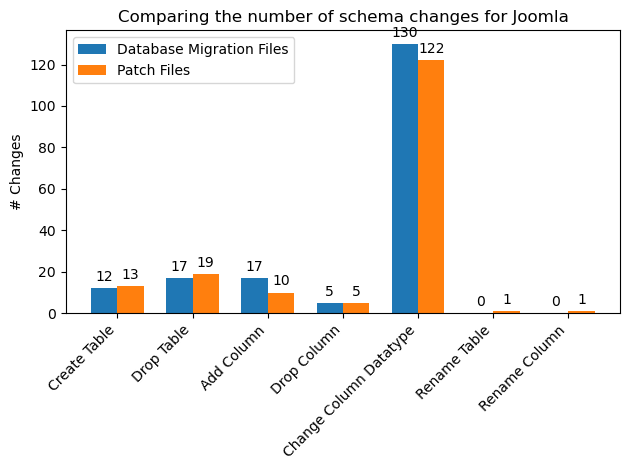

In [16]:
#Plot of Patch files and Database Migration files SMOs in the Joomla 


Joomla_Migration_columns = ['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num']
Joomla_Migration_values = Joomla_DMF_Sum_df.loc[Joomla_Migration_columns].values


if not Joomla_Patch_df.empty:
    Joomla_Patch_columns = ['Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column']
    Joomla_Patch_values = Joomla_Patch_df[Joomla_Patch_columns].values
else:
    Joomla_Patch_columns = ['Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column']
    Joomla_Patch_values = np.zeros(len(Joomla_Patch_columns))

bar_width = 0.35
index = np.arange(len(Joomla_Migration_values))
labels = ['Create Table', 'Drop Table', 'Add Column', 'Drop Column',
          'Change Column Datatype', 'Rename Table', 'Rename Column']
fig, ax = plt.subplots()
rects1 = ax.bar(index, Joomla_Migration_values, bar_width, label='Database Migration Files')
rects2 = ax.bar(index + bar_width, Joomla_Patch_values, bar_width, label='Patch Files')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('# Changes')
ax.set_title('Comparing the number of schema changes for Joomla')
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')


plt.tight_layout()
plt.show()

In [17]:
# Absolute difference and relative difference

Absolute_Difference = Joomla_Patch_df['SMOs_Total'] - Joomla_DMF_SMO_df["SMO's_Total"]
Relative_Difference = (Joomla_Patch_df['SMOs_Total'] - Joomla_DMF_SMO_df["SMO's_Total"]) / ((Joomla_Patch_df['SMOs_Total'] + Joomla_DMF_SMO_df["SMO's_Total"])/2) * 100

print("Absolute Difference:", abs(Absolute_Difference))
print("Relative Difference:", round(abs(float(Relative_Difference)), 2), "%")
print("Matching percent for Patch Files and Database Migration Files:", round(100 - round(abs(float(Relative_Difference)), 2), 2) ,"%")

Absolute Difference: 10
Relative Difference: 5.68 %
Matching percent for Patch Files and Database Migration Files: 94.32 %


In [18]:
#Absolute values and percent values

Joomla_Patch_Percent_df = Joomla_Patch_df

pattern = Joomla_Patch_Percent_df['Create_Table']  
Joomla_Patch_Percent_df['Percent_create'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Drop_Table']  
Joomla_Patch_Percent_df['Percent_drop'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Add_Column']  
Joomla_Patch_Percent_df['Percent_add'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Drop_Column']  
Joomla_Patch_Percent_df['Percent_dc'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Change_Column_Datatype']  
Joomla_Patch_Percent_df['Percent_ccd'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Rename_Table']  
Joomla_Patch_Percent_df['Percent_rt'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Rename_Column']  
Joomla_Patch_Percent_df['Percent_rc'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

print(Joomla_Patch_Percent_df)

Create_Table               13.0
Drop_Table                 19.0
Add_Column                 10.0
Drop_Column                 5.0
Change_Column_Datatype    122.0
Rename_Table                1.0
Rename_Column               1.0
SMOs_Total                171.0
Commit_Count              204.0
Percent_create              7.6
Percent_drop               11.1
Percent_add                 5.8
Percent_dc                  2.9
Percent_ccd                71.3
Percent_rt                  0.6
Percent_rc                  0.6
dtype: float64


In [19]:
# Compare CREATE table SMOs between patch files and database migration files.
Joomla_Create_Table = Joomla_Merged[['Version', 'Rename_Table', 'Create_Table']]
Joomla_DMF_CT = Joomla_DMF_df['CT num'].reset_index(drop=True)

Create_Table = pd.concat([Joomla_Create_Table, Joomla_DMF_CT], axis=1)
Create_Table['difference'] = Create_Table['Rename_Table'] + Create_Table['Create_Table'] - Create_Table['CT num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Create_Table = Create_Table.style.apply(diff_val, axis=1)
Create_Table

,Version,Rename_Table,Create_Table,CT num,difference
0,4.0.0-2018-03-05,0,0,0,0
1,4.0.0-2018-05-15,0,4,4,0
2,4.0.0-2018-07-19,0,1,1,0
3,4.0.0-2018-07-29,0,4,2,2
4,4.0.0-2018-08-29,0,0,0,0
5,4.0.0-2019-03-09,0,1,1,0
6,4.0.0-2019-03-30,0,0,0,0
7,4.0.0-2019-04-15,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0
9,4.0.0-2019-05-20,0,0,0,0


In [20]:
# Compare DROP table SMOs between patch files and database migration files.
Joomla_Drop_Table = Joomla_Merged[['Version', 'Rename_Table', 'Drop_Table']]
Joomla_DMF_DT = Joomla_DMF_df['DT num'].reset_index(drop=True)

Drop_Table = pd.concat([Joomla_Drop_Table, Joomla_DMF_DT], axis=1)
Drop_Table['difference'] = Drop_Table['Rename_Table'] + Drop_Table['Drop_Table'] - Drop_Table['DT num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Drop_Table = Drop_Table.style.apply(diff_val, axis=1)
Drop_Table

,Version,Rename_Table,Drop_Table,DT num,difference
0,4.0.0-2018-03-05,0,0,0,0
1,4.0.0-2018-05-15,0,0,0,0
2,4.0.0-2018-07-19,0,0,0,0
3,4.0.0-2018-07-29,0,18,16,2
4,4.0.0-2018-08-29,0,0,0,0
5,4.0.0-2019-03-09,0,0,0,0
6,4.0.0-2019-03-30,0,0,0,0
7,4.0.0-2019-04-15,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0
9,4.0.0-2019-05-20,0,0,0,0


In [21]:
# Compare ADD column SMOs between patch files and database migration files.
Joomla_Add_Column = Joomla_Merged[['Version', 'Rename_Column', 'Add_Column']]
Joomla_DMF_AC = Joomla_DMF_df['AC num'].reset_index(drop=True)

Add_Column = pd.concat([Joomla_Add_Column, Joomla_DMF_AC], axis=1)
Add_Column['difference'] = Add_Column['Rename_Column'] + Add_Column['Add_Column'] - Add_Column['AC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Add_Column = Add_Column.style.apply(diff_val, axis=1)
Add_Column

,Version,Rename_Column,Add_Column,AC num,difference
0,4.0.0-2018-03-05,0,0,0,0
1,4.0.0-2018-05-15,0,0,0,0
2,4.0.0-2018-07-19,0,0,0,0
3,4.0.0-2018-07-29,0,0,7,-7
4,4.0.0-2018-08-29,0,0,0,0
5,4.0.0-2019-03-09,0,0,0,0
6,4.0.0-2019-03-30,0,2,2,0
7,4.0.0-2019-04-15,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0
9,4.0.0-2019-05-20,0,1,1,0


In [22]:
# Compare DROP column SMOs between patch files and database migration files.
Joomla_Drop_Column = Joomla_Merged[['Version', 'Rename_Column', 'Drop_Column']]
Joomla_DMF_DC = Joomla_DMF_df['DC num'].reset_index(drop=True)

Drop_Column = pd.concat([Joomla_Drop_Column, Joomla_DMF_DC], axis=1)
Drop_Column['difference'] = Drop_Column['Rename_Column'] + Drop_Column['Drop_Column'] - Drop_Column['DC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Drop_Column = Drop_Column.style.apply(diff_val, axis=1)
Drop_Column

,Version,Rename_Column,Drop_Column,DC num,difference
0,4.0.0-2018-03-05,0,0,0,0
1,4.0.0-2018-05-15,0,0,0,0
2,4.0.0-2018-07-19,0,0,0,0
3,4.0.0-2018-07-29,0,1,2,-1
4,4.0.0-2018-08-29,0,0,0,0
5,4.0.0-2019-03-09,0,0,0,0
6,4.0.0-2019-03-30,0,0,0,0
7,4.0.0-2019-04-15,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0
9,4.0.0-2019-05-20,0,0,0,0


In [23]:
# Compare CHANGE COLUMN DATATYPE SMOs between patch files and database migration files.
Joomla_Change_Column_Datatype = Joomla_Merged[['Version', 'Change_Column_Datatype']]
Joomla_DMF_CC = Joomla_DMF_df['CC num'].reset_index(drop=True)

Change_Column_Datatype = pd.concat([Joomla_Change_Column_Datatype, Joomla_DMF_CC], axis=1)
Change_Column_Datatype['difference'] =  Change_Column_Datatype['Change_Column_Datatype'] - Change_Column_Datatype['CC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Change_Column_Datatype = Change_Column_Datatype.style.apply(diff_val, axis=1)
Change_Column_Datatype

,Version,Change_Column_Datatype,CC num,difference
0,4.0.0-2018-03-05,1,1,0
1,4.0.0-2018-05-15,0,0,0
2,4.0.0-2018-07-19,1,1,0
3,4.0.0-2018-07-29,28,41,-13
4,4.0.0-2018-08-29,8,8,0
5,4.0.0-2019-03-09,0,0,0
6,4.0.0-2019-03-30,1,1,0
7,4.0.0-2019-04-15,0,0,0
8,4.0.0-2019-04-22,5,5,0
9,4.0.0-2019-05-20,0,0,0


In [24]:
# Calculate SMOs total for patch files
Joomla_Patch_SMO = Joomla_Merged[['Version', 'SMOs_Total', 'Rename_Column', 'Rename_Table']].copy()
Joomla_Patch_SMO['SMOs_Total_RTC'] = Joomla_Patch_SMO['SMOs_Total'] + Joomla_Patch_SMO['Rename_Column'] + Joomla_Patch_SMO['Rename_Table']
print(Joomla_Patch_SMO[['Version', 'SMOs_Total_RTC']])

             Version  SMOs_Total_RTC
0   4.0.0-2018-03-05               1
1   4.0.0-2018-05-15               4
2   4.0.0-2018-07-19               2
3   4.0.0-2018-07-29              51
4   4.0.0-2018-08-29               8
5   4.0.0-2019-03-09               1
6   4.0.0-2019-03-30               3
7   4.0.0-2019-04-15               0
8   4.0.0-2019-04-22               5
9   4.0.0-2019-05-20               1
10  4.0.0-2019-06-29              12
11  4.0.0-2019-07-13               1
12  4.0.0-2019-09-13               7
13  4.0.0-2019-09-22               6
14  4.0.0-2019-10-06              27
15  4.0.0-2019-10-17               3
16  4.0.0-2020-02-02               0
17  4.0.0-2020-03-10               8
18  4.0.0-2020-03-25               2
19  4.0.0-2020-05-29              25
20  4.0.0-2020-09-27               0
21  4.0.0-2020-12-20               0
22  4.0.0-2021-04-22               2
23  4.0.0-2021-04-27               0
24  4.0.0-2021-05-30               1
25  4.0.0-2021-06-04               0
2

In [25]:
# Compare total SMOs between patch files and database migration files.
Joomla_Patch_SMO = Joomla_Patch_SMO[['Version', 'SMOs_Total_RTC']]
Joomla_DMF_SMO = Joomla_DMF_df["SMO's_Total"].reset_index(drop=True)

Joomla_SMO_Merge = pd.concat([Joomla_Patch_SMO, Joomla_DMF_SMO], axis=1)
Joomla_SMO_Merge_Diff = pd.concat([Joomla_Patch_SMO, Joomla_DMF_SMO], axis=1)
Joomla_SMO_Merge_Diff['difference'] =  Joomla_SMO_Merge_Diff['SMOs_Total_RTC'] - Joomla_SMO_Merge_Diff["SMO's_Total"]

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Joomla_SMO_Merge_Diff = Joomla_SMO_Merge_Diff.style.apply(diff_val, axis=1)
Joomla_SMO_Merge_Diff

,Version,SMOs_Total_RTC,SMO's_Total,difference
0,4.0.0-2018-03-05,1,1,0
1,4.0.0-2018-05-15,4,4,0
2,4.0.0-2018-07-19,2,2,0
3,4.0.0-2018-07-29,51,68,-17
4,4.0.0-2018-08-29,8,8,0
5,4.0.0-2019-03-09,1,1,0
6,4.0.0-2019-03-30,3,3,0
7,4.0.0-2019-04-15,0,0,0
8,4.0.0-2019-04-22,5,5,0
9,4.0.0-2019-05-20,1,1,0


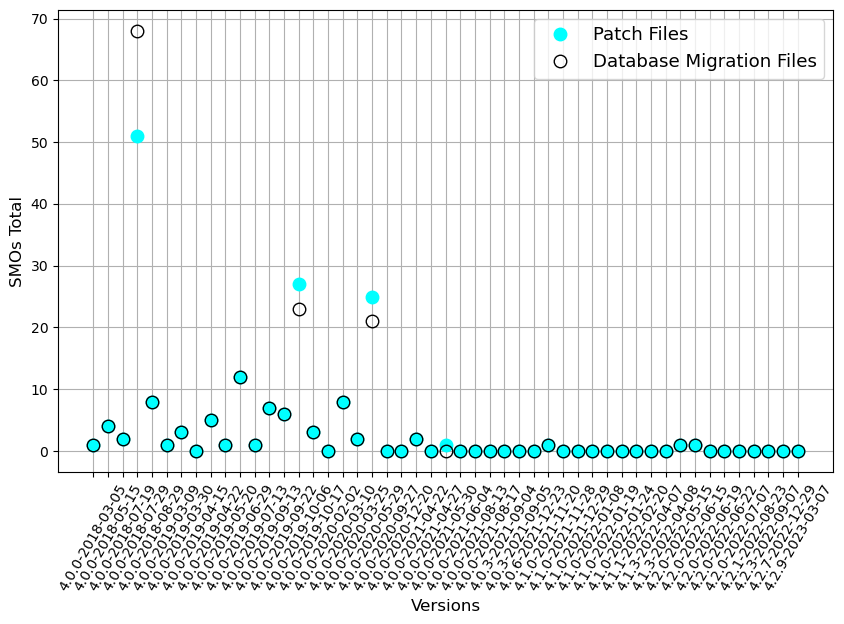

In [26]:
# Plot of Patch files and Database Migration files each version in the Joomla

Joomla_Version = Joomla_Patch_SMO['Version'].str.replace('upgrade', '')  
Joomla_SMOs_Total = Joomla_Patch_SMO['SMOs_Total_RTC']

plt.figure(figsize=(10, 6)) 
plt.plot(Joomla_Version, Joomla_SMOs_Total, marker='o', color='#00FFFF', label='Patch Files', linestyle='', markersize=9, linewidth=5)
##FF3399
DMF_index = Joomla_DMF_SMO.index
DMF_SMOs_Total = Joomla_DMF_SMO.values

plt.plot(DMF_index, DMF_SMOs_Total, marker='o', color='black', label="Database Migration Files", linestyle='', markersize=9, markerfacecolor='none', markeredgecolor='black', linewidth=5)
plt.xlabel('Versions', fontsize=12)
plt.ylabel("SMOs Total", fontsize=12)
plt.xticks(rotation=60)
plt.grid(True)
plt.legend(fontsize=13.1)

plt.show()

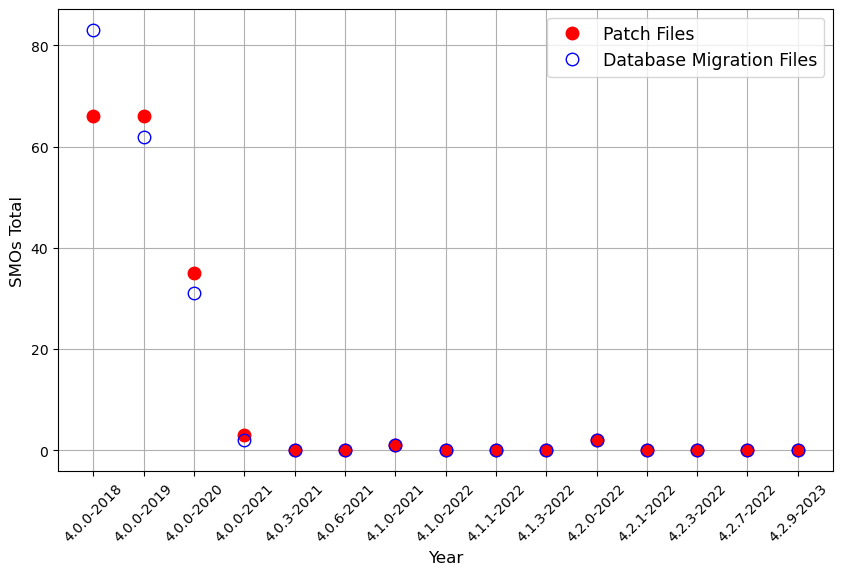

In [27]:
# Plot of Patch files and Database Migration files each year in the Joomla

Version_Patch = Joomla_SMO_Merge['Version']
SMOs_Total_Patch = Joomla_SMO_Merge['SMOs_Total_RTC']
SMOs_Total_DMF = Joomla_SMO_Merge["SMO's_Total"]

Joomla_SMO_Merge['Version'] = Joomla_SMO_Merge['Version'].str[:10]
grouped_data = Joomla_SMO_Merge.groupby('Version').sum()
Version = grouped_data.index
SMOs_Total_Patch = grouped_data['SMOs_Total_RTC']
SMOs_Total_DMF = grouped_data["SMO's_Total"]

plt.figure(figsize=(10, 6))  
plt.plot(Version, SMOs_Total_Patch, marker='o', color='r', label='Patch Files', linestyle='', markersize=9, linewidth=15)
plt.plot(Version, SMOs_Total_DMF, marker='o', color='b', label='Database Migration Files', linestyle='', markersize=9, markerfacecolor='none', markeredgecolor='b', linewidth=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel("SMOs Total", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12.5)
plt.xticks(rotation=45)

plt.show()

In [28]:
# Concatenate the two DataFrames, Extract the required columns for the table level and column level.
Joomla_Patch_df = Joomla_Merged[['Version', 'Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column', "SMOs_Total"]]
Joomla_DMF_df = Joomla_DMF_df[['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num']].reset_index(drop=True)

Joomla_Patch_DMF_df = pd.concat([Joomla_Patch_df, Joomla_DMF_df], axis=1)

Joomla_Table_df = Joomla_Patch_DMF_df[['Version', 'Create_Table', 'Rename_Table', 'CT num','Drop_Table','Rename_Table','DT num']]
Joomla_Column_df= Joomla_Patch_DMF_df[['Version', 'Add_Column', 'Rename_Column','AC num', 'Drop_Column', 'Rename_Column','DC num', 'Change_Column_Datatype', 'CC num']]

In [29]:
# Table level smos
Joomla_Table_df

,Version,Create_Table,Rename_Table,CT num,Drop_Table,Rename_Table,DT num
0,4.0.0-2018-03-05,0,0,0,0,0,0
1,4.0.0-2018-05-15,4,0,4,0,0,0
2,4.0.0-2018-07-19,1,0,1,0,0,0
3,4.0.0-2018-07-29,4,0,2,18,0,16
4,4.0.0-2018-08-29,0,0,0,0,0,0
5,4.0.0-2019-03-09,1,0,1,0,0,0
6,4.0.0-2019-03-30,0,0,0,0,0,0
7,4.0.0-2019-04-15,0,0,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0,0,0
9,4.0.0-2019-05-20,0,0,0,0,0,0


In [30]:
# Column level smos
Joomla_Column_df

,Version,Add_Column,Rename_Column,AC num,Drop_Column,Rename_Column,DC num,Change_Column_Datatype,CC num
0,4.0.0-2018-03-05,0,0,0,0,0,0,1,1
1,4.0.0-2018-05-15,0,0,0,0,0,0,0,0
2,4.0.0-2018-07-19,0,0,0,0,0,0,1,1
3,4.0.0-2018-07-29,0,0,7,1,0,2,28,41
4,4.0.0-2018-08-29,0,0,0,0,0,0,8,8
5,4.0.0-2019-03-09,0,0,0,0,0,0,0,0
6,4.0.0-2019-03-30,2,0,2,0,0,0,1,1
7,4.0.0-2019-04-15,0,0,0,0,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0,0,0,5,5
9,4.0.0-2019-05-20,1,0,1,0,0,0,0,0


In [31]:
# Extract table count and table names from database migration files.

os.chdir('..')
MigrationFiles_Path = "{}/Datasets/Joomla/Input/Migration_Files".format(os.getcwd())

File_Names = []
Table_Counts = []
Table_Names = []

for Filename in os.listdir(MigrationFiles_Path):
    if Filename.endswith('.sql'):
        File_Path = os.path.join(MigrationFiles_Path, Filename)

        with open(File_Path, 'r') as File:
            Content = File.read()
            
        DDL_Statements = Content.split(';')
        Count = 0
        Names = []

        for Statement in DDL_Statements:
            if 'CREATE TABLE' in Statement:
                Table_Name = Statement.split('CREATE TABLE')[1].split('(')[0].strip()
                Names.append(Table_Name)
                Count += 1

        File_Names.append(Filename)
        Table_Counts.append(Count)
        Table_Names.append(Names)


Column_Names = {'file name': File_Names, 'table_count': Table_Counts, 'table_names': Table_Names}
Joomla_Table_List_df = pd.DataFrame(Column_Names)
print(Joomla_Table_List_df)

Joomla_Table_Filename = "{}/Datasets/Joomla/Output/Joomla_Databseschemafiles_table_list.csv".format(os.getcwd())
Joomla_Table_List_df.to_csv(Joomla_Table_Filename, index=False)
print("Joomla Table List saved to: {}".format(Joomla_Table_Filename))
os.chdir('Code')

                          file name  table_count  \
0   joomla_4.0.0-2018-02-24_mod.sql           72   
1   joomla_4.0.0-2018-03-05_mod.sql           72   
2   joomla_4.0.0-2018-05-15_mod.sql           76   
3   joomla_4.0.0-2018-07-19_mod.sql           77   
4   joomla_4.0.0-2018-07-29_mod.sql           63   
5   joomla_4.0.0-2018-08-29_mod.sql           63   
6   joomla_4.0.0-2019-03-09_mod.sql           64   
7   joomla_4.0.0-2019-03-30_mod.sql           64   
8   joomla_4.0.0-2019-04-15_mod.sql           64   
9   joomla_4.0.0-2019-04-22_mod.sql           64   
10  joomla_4.0.0-2019-05-20_mod.sql           64   
11  joomla_4.0.0-2019-06-29_mod.sql           64   
12  joomla_4.0.0-2019-07-13_mod.sql           65   
13  joomla_4.0.0-2019-09-13_mod.sql           65   
14  joomla_4.0.0-2019-09-22_mod.sql           65   
15  joomla_4.0.0-2019-10-06_mod.sql           65   
16  joomla_4.0.0-2019-10-17_mod.sql           65   
17  joomla_4.0.0-2020-02-02_mod.sql           65   
18  joomla_4

In [32]:
# Calculate the total number of tables increased in joomla
Joomla_Total_Tables_Increased =  Joomla_Table_List_df.iloc[-1]['table_count'] - Joomla_Table_List_df.iloc[0]['table_count']
print("Total number of tables increased in Joomla: {}".format(Joomla_Total_Tables_Increased))

Total number of tables increased in Joomla: -5


### webERP Results

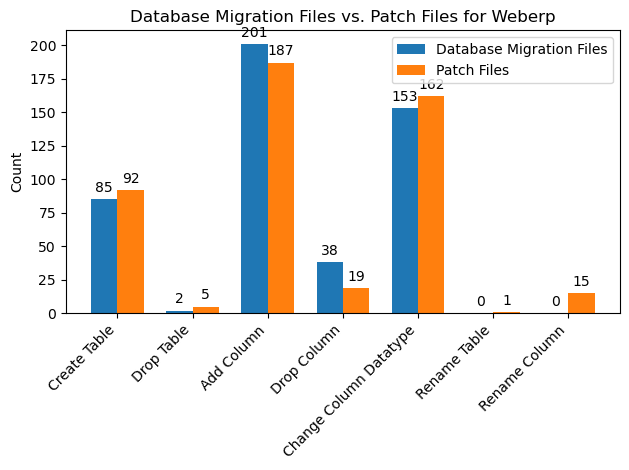

In [33]:
#Plot of Patch files and Database Migration files SMOs in the dataset
Weberp_DMF_columns = ['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num']
Weberp_DMF_values = Weberp_DMF_Sum_df.loc[Weberp_DMF_columns].values

Weberp_Patch_columns = ['Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column']
Weberp_Patch_values =  Weberp_Patch_df.loc[Weberp_Patch_columns].values


bar_width = 0.35
index = np.arange(len(Weberp_DMF_values))
labels = ['Create Table', 'Drop Table', 'Add Column', 'Drop Column',
          'Change Column Datatype', 'Rename Table', 'Rename Column']
fig, ax = plt.subplots()
rects1 = ax.bar(index, Weberp_DMF_values, bar_width, label='Database Migration Files')
rects2 = ax.bar(index + bar_width, Weberp_Patch_values, bar_width, label='Patch Files')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Database Migration Files vs. Patch Files for Weberp')
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [34]:
# Absolute difference and relative difference

Absolute_Difference = Weberp_Patch_df['SMOs_Total'] - Weberp_DMF_Sum_df["SMO's_Total"]
Relative_Difference = (Weberp_Patch_df['SMOs_Total'] - Weberp_DMF_Sum_df["SMO's_Total"]) / ((Weberp_Patch_df['SMOs_Total'] + Weberp_DMF_Sum_df["SMO's_Total"])/2) * 100

print("Absolute Difference:", Absolute_Difference)
print("Relative Difference:", round(Relative_Difference, 2), "%")
print("Matching percent for Patch Files and Database Migration Files:", round(100 - round(abs(float(Relative_Difference)), 2), 2) ,"%")

Absolute Difference: 2
Relative Difference: 0.42 %
Matching percent for Patch Files and Database Migration Files: 99.58 %


In [35]:
#Absolute values and percent values

Weberp_Patch_Percent_df = Weberp_Patch_df

pattern = Weberp_Patch_Percent_df['Create_Table']  
Weberp_Patch_Percent_df['Percent_create'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Drop_Table']  
Weberp_Patch_Percent_df['Percent_drop'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Add_Column']  
Weberp_Patch_Percent_df['Percent_add'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Drop_Column']  
Weberp_Patch_Percent_df['Percent_dc'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Change_Column_Datatype']  
Weberp_Patch_Percent_df['Percent_ccd'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Rename_Table']  
Weberp_Patch_Percent_df['Percent_rt'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Rename_Column']  
Weberp_Patch_Percent_df['Percent_rc'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

print(Weberp_Patch_Percent_df)

Create_Table               92.0
Drop_Table                  5.0
Add_Column                187.0
Drop_Column                19.0
Change_Column_Datatype    162.0
Rename_Table                1.0
Rename_Column              15.0
SMOs_Total                481.0
Commit_Count              405.0
Percent_create             19.1
Percent_drop                1.0
Percent_add                38.9
Percent_dc                  4.0
Percent_ccd                33.7
Percent_rt                  0.2
Percent_rc                  3.1
dtype: float64


In [36]:
# Compare CREATE table SMOs between patch files and database migration files.
Weberp_Patch_Create_Table = Weberp_Merged[['Version', 'Rename_Table', 'Create_Table']]
Weberp_DMF_CT = Weberp_DMF_df['CT num'].reset_index(drop=True)

Create_Table = pd.concat([Weberp_Patch_Create_Table, Weberp_DMF_CT], axis=1)
Create_Table['difference'] = Create_Table['Rename_Table'] + Create_Table['Create_Table'] - Create_Table['CT num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Create_Table = Create_Table.style.apply(diff_val, axis=1)
Create_Table

,Version,Rename_Table,Create_Table,CT num,difference
0,upgrade3.00-3.01,0,0,0,0
1,upgrade3.01-3.02,1,7,8,0
2,upgrade3.02-3.03,0,0,0,0
3,upgrade3.03-3.04,0,0,0,0
4,upgrade3.04-3.05,0,3,3,0
5,upgrade3.05-3.06,0,3,3,0
6,upgrade3.06-3.07,0,2,2,0
7,upgrade3.07-3.08,0,0,0,0
8,upgrade3.08-3.09,0,3,3,0
9,upgrade3.09-3.10,0,7,6,1


In [37]:
# Compare DROP table SMOs between patch files and database migration files.
Weberp_Patch_Drop_Table = Weberp_Merged[['Version', 'Rename_Table', 'Drop_Table']]
Weberp_DMF_DT = Weberp_DMF_df['DT num'].reset_index(drop=True)

Drop_Table = pd.concat([Weberp_Patch_Drop_Table, Weberp_DMF_DT], axis=1)
Drop_Table['difference'] = Drop_Table['Rename_Table'] + Drop_Table['Drop_Table'] - Drop_Table['DT num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Drop_Table = Drop_Table.style.apply(diff_val, axis=1)
Drop_Table

,Version,Rename_Table,Drop_Table,DT num,difference
0,upgrade3.00-3.01,0,0,0,0
1,upgrade3.01-3.02,1,0,1,0
2,upgrade3.02-3.03,0,0,0,0
3,upgrade3.03-3.04,0,0,0,0
4,upgrade3.04-3.05,0,0,0,0
5,upgrade3.05-3.06,0,1,1,0
6,upgrade3.06-3.07,0,0,0,0
7,upgrade3.07-3.08,0,0,0,0
8,upgrade3.08-3.09,0,0,0,0
9,upgrade3.09-3.10,0,0,0,0


In [38]:
# Compare ADD column SMOs between patch files and database migration files.
Weberp_Patch_Add_Column = Weberp_Merged[['Version', 'Rename_Column', 'Add_Column']]
Weberp_DMF_AC = Weberp_DMF_df['AC num'].reset_index(drop=True)

Add_Column = pd.concat([Weberp_Patch_Add_Column, Weberp_DMF_AC], axis=1)
Add_Column['difference'] = Add_Column['Rename_Column'] + Add_Column['Add_Column'] - Add_Column['AC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Add_Column = Add_Column.style.apply(diff_val, axis=1)
Add_Column

,Version,Rename_Column,Add_Column,AC num,difference
0,upgrade3.00-3.01,0,0,0,0
1,upgrade3.01-3.02,6,2,6,2
2,upgrade3.02-3.03,4,20,21,3
3,upgrade3.03-3.04,0,0,0,0
4,upgrade3.04-3.05,0,1,1,0
5,upgrade3.05-3.06,0,3,3,0
6,upgrade3.06-3.07,0,0,0,0
7,upgrade3.07-3.08,0,3,3,0
8,upgrade3.08-3.09,0,6,6,0
9,upgrade3.09-3.10,0,9,8,1


In [39]:
# Compare DROP column SMOs between patch files and database migration files.
Weberp_Patch_Drop_Column = Weberp_Merged[['Version', 'Rename_Column', 'Drop_Column']]
Weberp_DMF_DC = Weberp_DMF_df['DC num'].reset_index(drop=True)

Drop_Column = pd.concat([Weberp_Patch_Drop_Column, Weberp_DMF_DC], axis=1)
Drop_Column['difference'] = Drop_Column['Rename_Column'] + Drop_Column['Drop_Column'] - Drop_Column['DC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Drop_Column = Drop_Column.style.apply(diff_val, axis=1)
Drop_Column

,Version,Rename_Column,Drop_Column,DC num,difference
0,upgrade3.00-3.01,0,0,0,0
1,upgrade3.01-3.02,6,1,5,2
2,upgrade3.02-3.03,4,0,1,3
3,upgrade3.03-3.04,0,2,0,2
4,upgrade3.04-3.05,0,0,0,0
5,upgrade3.05-3.06,0,0,0,0
6,upgrade3.06-3.07,0,0,0,0
7,upgrade3.07-3.08,0,0,0,0
8,upgrade3.08-3.09,0,0,0,0
9,upgrade3.09-3.10,0,3,0,3


In [40]:
# Compare CHANGE COLUMN DATATYPE SMOs between patch files and database migration files.
Weberp_Patch_Change_Column_Datatype = Weberp_Merged[['Version', 'Change_Column_Datatype']]
Weberp_DMF_CC = Weberp_DMF_df['CC num'].reset_index(drop=True)

Change_Column_Datatypes = pd.concat([Weberp_Patch_Change_Column_Datatype, Weberp_DMF_CC], axis=1)
Change_Column_Datatypes['difference'] =  Change_Column_Datatypes['Change_Column_Datatype'] - Change_Column_Datatypes['CC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Change_Column_Datatypes = Change_Column_Datatypes.style.apply(diff_val, axis=1)
Change_Column_Datatypes

,Version,Change_Column_Datatype,CC num,difference
0,upgrade3.00-3.01,1,1,0
1,upgrade3.01-3.02,0,0,0
2,upgrade3.02-3.03,6,9,-3
3,upgrade3.03-3.04,1,1,0
4,upgrade3.04-3.05,0,0,0
5,upgrade3.05-3.06,1,0,1
6,upgrade3.06-3.07,0,0,0
7,upgrade3.07-3.08,0,0,0
8,upgrade3.08-3.09,2,2,0
9,upgrade3.09-3.10,3,3,0


In [41]:
# Calculate SMOs total for patch files
Weberp_Patch_SMO = Weberp_Merged[['Version', 'SMOs_Total', 'Rename_Column', 'Rename_Table']].copy()
Weberp_Patch_SMO['SMOs_Total_RTC'] = Weberp_Patch_SMO['SMOs_Total'] + Weberp_Patch_SMO['Rename_Column'] + Weberp_Patch_SMO['Rename_Table']
print(Weberp_Patch_SMO[['Version', 'SMOs_Total_RTC']])

                 Version  SMOs_Total_RTC
0       upgrade3.00-3.01               1
1       upgrade3.01-3.02              24
2       upgrade3.02-3.03              34
3       upgrade3.03-3.04               3
4       upgrade3.04-3.05               4
5       upgrade3.05-3.06               8
6       upgrade3.06-3.07               2
7       upgrade3.07-3.08               3
8       upgrade3.08-3.09              11
9       upgrade3.09-3.10              22
10      upgrade3.10-3.11              46
11    upgrade3.11-3.11.1               0
12    upgrade3.11.1-4.00              93
13      upgrade4.03-4.04               0
14    upgrade4.04-4.04.1               2
15  upgrade4.04.1-4.04.4               1
16  upgrade4.04.4-4.04.5               1
17    upgrade4.04.5-4.05               0
18      upgrade4.05-4.06               3
19      upgrade4.06-4.07               4
20      upgrade4.07-4.08              29
21      upgrade4.08-4.09               8
22      upgrade4.09-4.10              10
23      upgrade4

In [42]:
# Compare total SMOs between patch files and database migration files.
weberp_Patch_SMO = Weberp_Patch_SMO[['Version', 'SMOs_Total_RTC']]
Weberp_DMF_SMO = Weberp_DMF_df["SMO's_Total"].reset_index(drop=True)

Weberp_SMO_Merge = pd.concat([weberp_Patch_SMO, Weberp_DMF_SMO], axis=1)
Weberp_SMO_Merge_diff = pd.concat([weberp_Patch_SMO, Weberp_DMF_SMO], axis=1)
Weberp_SMO_Merge_diff['difference'] =  Weberp_SMO_Merge_diff['SMOs_Total_RTC'] - Weberp_SMO_Merge_diff["SMO's_Total"]

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Weberp_SMO_Merge_diff = Weberp_SMO_Merge_diff.style.apply(diff_val, axis=1)
Weberp_SMO_Merge_diff

,Version,SMOs_Total_RTC,SMO's_Total,difference
0,upgrade3.00-3.01,1,1,0
1,upgrade3.01-3.02,24,20,4
2,upgrade3.02-3.03,34,31,3
3,upgrade3.03-3.04,3,1,2
4,upgrade3.04-3.05,4,4,0
5,upgrade3.05-3.06,8,7,1
6,upgrade3.06-3.07,2,2,0
7,upgrade3.07-3.08,3,3,0
8,upgrade3.08-3.09,11,11,0
9,upgrade3.09-3.10,22,17,5


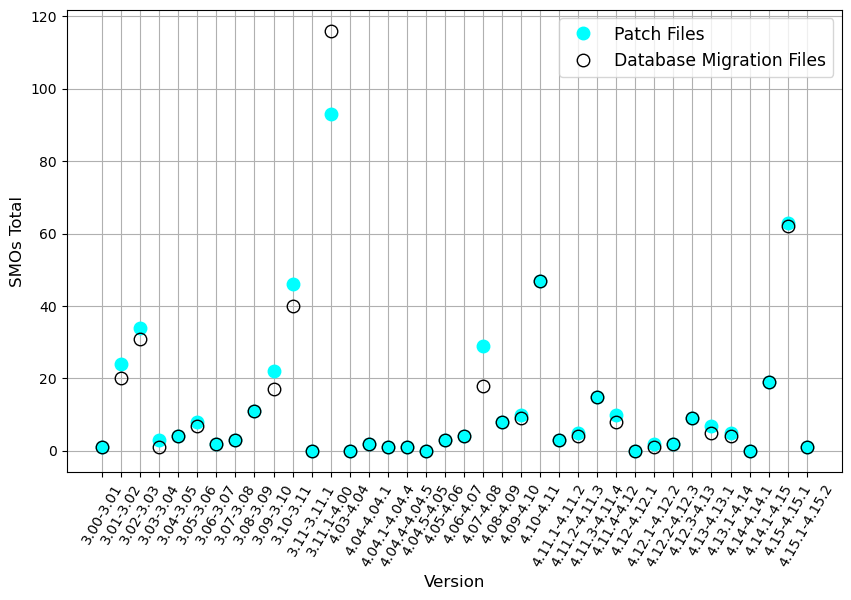

In [43]:
# Plot of Patch files and Database Migration files each version in the dataset
Weberp_Version = Weberp_Patch_SMO['Version'].str.replace('upgrade', '')  
Weberp_SMOs_Total = Weberp_Patch_SMO['SMOs_Total_RTC']

plt.figure(figsize=(10, 6))  
plt.plot(Weberp_Version, Weberp_SMOs_Total, marker='o', color='#00FFFF', label='Patch Files', linestyle='', markersize=9)
DMF_index = Weberp_DMF_SMO.index
DMF_smos_total = Weberp_DMF_SMO.values
plt.plot(DMF_index, DMF_smos_total, marker='o', color='black', label="Database Migration Files", linestyle='', markersize=9, markerfacecolor='none', markeredgecolor='black')
plt.xlabel('Version', fontsize=12)
plt.ylabel("SMOs Total", fontsize=12)
plt.xticks(rotation=60)
plt.grid(True)
plt.legend(fontsize=12.4)

plt.show()

In [44]:
# Concatenate the two DataFrames, Extract the required columns for the table level and column level.
Weberp_Patch_df = Weberp_Merged[['Version', 'Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column', "SMOs_Total"]]
Weberp_DMF_df = Weberp_DMF_df[['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num']].reset_index(drop=True)

Weberp_Patch_DMF_df = pd.concat([Weberp_Patch_df, Weberp_DMF_df], axis=1)
Weberp_Table_df = Weberp_Patch_DMF_df[['Version', 'Create_Table', 'Rename_Table', 'CT num','Drop_Table','Rename_Table','DT num']]
Weberp_Column_df= Weberp_Patch_DMF_df[['Version', 'Add_Column', 'Rename_Column','AC num', 'Drop_Column', 'Rename_Column','DC num', 'Change_Column_Datatype', 'CC num']]

In [45]:
# Table level smos
Weberp_Table_df

,Version,Create_Table,Rename_Table,CT num,Drop_Table,Rename_Table,DT num
0,upgrade3.00-3.01,0,0,0,0,0,0
1,upgrade3.01-3.02,7,1,8,0,1,1
2,upgrade3.02-3.03,0,0,0,0,0,0
3,upgrade3.03-3.04,0,0,0,0,0,0
4,upgrade3.04-3.05,3,0,3,0,0,0
5,upgrade3.05-3.06,3,0,3,1,0,1
6,upgrade3.06-3.07,2,0,2,0,0,0
7,upgrade3.07-3.08,0,0,0,0,0,0
8,upgrade3.08-3.09,3,0,3,0,0,0
9,upgrade3.09-3.10,7,0,6,0,0,0


In [46]:
# Column level smos
Weberp_Column_df

,Version,Add_Column,Rename_Column,AC num,Drop_Column,Rename_Column,DC num,Change_Column_Datatype,CC num
0,upgrade3.00-3.01,0,0,0,0,0,0,1,1
1,upgrade3.01-3.02,2,6,6,1,6,5,0,0
2,upgrade3.02-3.03,20,4,21,0,4,1,6,9
3,upgrade3.03-3.04,0,0,0,2,0,0,1,1
4,upgrade3.04-3.05,1,0,1,0,0,0,0,0
5,upgrade3.05-3.06,3,0,3,0,0,0,1,0
6,upgrade3.06-3.07,0,0,0,0,0,0,0,0
7,upgrade3.07-3.08,3,0,3,0,0,0,0,0
8,upgrade3.08-3.09,6,0,6,0,0,0,2,2
9,upgrade3.09-3.10,9,0,8,3,0,0,3,3


In [47]:
# Extract table count and table names from database migration files.


os.chdir('..')
MigrationFiles_Path = "{}/Datasets/WebERP/Input/Migration_Files".format(os.getcwd())

File_Names = []
Table_Counts = []
Table_Names = []

for Filename in os.listdir(MigrationFiles_Path):
    if Filename.endswith('.sql'):
        File_Path = os.path.join(MigrationFiles_Path, Filename)

        with open(File_Path, 'r') as File:
            Content = File.read()
            
        DDL_Statements = Content.split(';')
        Count = 0
        Names = []

        for Statement in DDL_Statements:
            if 'CREATE TABLE' in Statement:
                Table_Name = Statement.split('CREATE TABLE')[1].split('(')[0].strip()
                Names.append(Table_Name)
                Count += 1

        File_Names.append(Filename)
        Table_Counts.append(Count)
        Table_Names.append(Names)

Column_Names = {'file name': File_Names, 'table_count': Table_Counts, 'table_names': Table_Names}
Weberp_Table_list_df = pd.DataFrame(Column_Names)
print(Weberp_Table_list_df)

Weberp_Table_list = "{}/Datasets/WebERP/Output/Weberp_Databaseschemafiles_table_list.csv".format(os.getcwd())
Weberp_Table_list_df.to_csv(Weberp_Table_list, index=False)
print("Weberp Table List saved to: {}".format(Weberp_Table_list))
os.chdir('Code')

                          file name  table_count  \
0      Weberp-3.0-demo_mod_sort.sql           78   
1     Weberp-3.01-demo_mod_sort.sql           78   
2     Weberp-3.02-demo_mod_sort.sql           85   
3     Weberp-3.03-demo_mod_sort.sql           85   
4     Weberp-3.04-demo_mod_sort.sql           85   
5     Weberp-3.05-demo_mod_sort.sql           88   
6     Weberp-3.06-demo_mod_sort.sql           90   
7     Weberp-3.07-demo_mod_sort.sql           92   
8     Weberp-3.08-demo_mod_sort.sql           92   
9     Weberp-3.09-demo_mod_sort.sql           95   
10    Weberp-3.10-demo_mod_sort.sql          101   
11    Weberp-3.11-demo_mod_sort.sql          107   
12  Weberp-3.11.1-demo_mod_sort.sql          107   
13    Weberp-4.00-demo_mod_sort.sql          122   
14    Weberp-4.04-demo_mod_sort.sql          122   
15  Weberp-4.04.1-demo_mod_sort.sql          122   
16  Weberp-4.04.4-demo_mod_sort.sql          122   
17  Weberp-4.04.5-demo_mod_sort.sql          122   
18    Weberp

In [48]:
# Calculate the total number of tables increased in Weberp
Weberp_Total_Tables_Increased =  Weberp_Table_list_df.iloc[-1]['table_count'] - Weberp_Table_list_df.iloc[0]['table_count']
print("Total number of tables increased in Weberp: {}".format(Weberp_Total_Tables_Increased))

Total number of tables increased in Weberp: 83


In [49]:
# Extract DDL statements include both 'ADD COLUMN' and 'ADD INDEX'.
os.chdir('..')
PatchFiles_Path = "{}/Datasets/Weberp/Input/Patch_Files/Git_WebERP/sql/mysql/".format(os.getcwd())

for Filename in os.listdir(PatchFiles_Path):
    if Filename.endswith(".sql"):
        PatchFiles = os.path.join(PatchFiles_Path, Filename)

        with open(PatchFiles, 'r') as File:
            lines = File.readlines()

        # Extract lines with "ALTER TABLE" and both "ADD" and "ADD INDEX" statements
        Add_AddIndex_Lines = [
            line.strip()
            for line in lines
            if "ALTER TABLE" in line and "ADD" in line and "," in line and "ADD INDEX" in line and "DROP INDEX" not in line and \
            "`," not in line
        ]

        for line in Add_AddIndex_Lines:
            print(f"File: {Filename}, Line: {line}")
os.chdir('Code')           

File: upgrade4.09-4.10.sql, Line: ALTER TABLE `salesorders` ADD `salesperson` VARCHAR( 4 ) NOT NULL , ADD INDEX ( `salesperson` );
File: upgrade4.09-4.10.sql, Line: ALTER TABLE `locstock` ADD `bin` VARCHAR( 10 ) NOT NULL , ADD INDEX ( `bin` );
File: upgrade4.10-4.11.sql, Line: ALTER TABLE `debtortrans` ADD `salesperson` VARCHAR( 4 ) NOT NULL DEFAULT '' , ADD INDEX ( `salesperson` );
File: upgrade4.11.3-4.11.4.sql, Line: ALTER TABLE  `stockmoves` ADD  `userid` VARCHAR( 20 ) NOT NULL , ADD INDEX (  `userid` ) ;
File: upgrade4.14.1-4.15.sql, Line: ALTER TABLE `stockserialitems` ADD `createdate` timestamp NULL DEFAULT CURRENT_TIMESTAMP, ADD INDEX (`createdate`);


### Roundcube Results

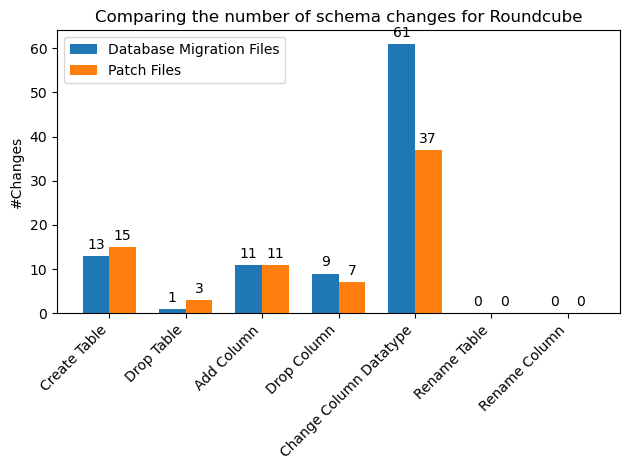

In [50]:
#Plot of Patch files and Database Migration files SMOs in the dataset
Roundcube_DMF_columns = ['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num']
Roundcube_DMF_values = Roundcube_DMF_Sum_df.loc[Roundcube_DMF_columns].values

Roundcube_Patch_columns = ['Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column']
Roundcube_Patch_values = Roundcube_Patch_df.loc[Roundcube_Patch_columns].values

bar_width = 0.35
index = np.arange(len(Roundcube_DMF_values))
labels = ['Create Table', 'Drop Table', 'Add Column', 'Drop Column',
          'Change Column Datatype', 'Rename Table', 'Rename Column']

if len(Roundcube_DMF_values) < len(labels):
    labels = labels[:len(Roundcube_DMF_values)]
elif len(Roundcube_DMF_values) > len(labels):
    Roundcube_DMF_values = Roundcube_DMF_values[:len(labels)]
    Roundcube_Patch_values = Roundcube_Patch_values[:len(labels)]
    index = index[:len(labels)]
    
fig, ax = plt.subplots()
rects1 = ax.bar(index, Roundcube_DMF_values, bar_width, label='Database Migration Files')
rects2 = ax.bar(index + bar_width, Roundcube_Patch_values, bar_width, label='Patch Files')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('#Changes')
ax.set_title('Comparing the number of schema changes for Roundcube')
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [51]:
# Absolute difference and relative difference

Absolute_Difference = Roundcube_Patch_df['SMOs_Total'] - Roundcube_DMF_Sum_df["SMO's_Total"]
Relative_Difference = (Roundcube_Patch_df['SMOs_Total'] - Roundcube_DMF_Sum_df["SMO's_Total"]) / ((Roundcube_Patch_df['SMOs_Total'] + Roundcube_DMF_Sum_df["SMO's_Total"])/2) * 100

print("Absolute Difference:", abs(Absolute_Difference))
print("Relative Difference:", round(abs(Relative_Difference), 2), "%")
print("Matching percent for Patch Files and Database Migration Files:", round(100 - round(abs(float(Relative_Difference)), 2), 2) ,"%")

Absolute Difference: 22
Relative Difference: 26.19 %
Matching percent for Patch Files and Database Migration Files: 73.81 %


In [52]:
#Absolute values and percent values

Roundcube_Patch_Percent_df = Roundcube_Patch_df

pattern = Roundcube_Patch_Percent_df['Create_Table']  
Roundcube_Patch_Percent_df['Percent_create'] = round((pattern / Roundcube_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Roundcube_Patch_Percent_df['Drop_Table']  
Roundcube_Patch_Percent_df['Percent_drop'] = round((pattern / Roundcube_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Roundcube_Patch_Percent_df['Add_Column']  
Roundcube_Patch_Percent_df['Percent_add'] = round((pattern / Roundcube_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Roundcube_Patch_Percent_df['Drop_Column']  
Roundcube_Patch_Percent_df['Percent_dc'] = round((pattern / Roundcube_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Roundcube_Patch_Percent_df['Change_Column_Datatype']  
Roundcube_Patch_Percent_df['Percent_ccd'] = round((pattern / Roundcube_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Roundcube_Patch_Percent_df['Rename_Table']  
Roundcube_Patch_Percent_df['Percent_rt'] = round((pattern / Roundcube_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Roundcube_Patch_Percent_df['Rename_Column']  
Roundcube_Patch_Percent_df['Percent_rc'] = round((pattern / Roundcube_Patch_Percent_df['SMOs_Total']) * 100,1)

print(Roundcube_Patch_Percent_df)

Create_Table              15.0
Drop_Table                 3.0
Add_Column                11.0
Drop_Column                7.0
Change_Column_Datatype    37.0
Rename_Table               0.0
Rename_Column              0.0
SMOs_Total                73.0
Commit_Count              46.0
Percent_create            20.5
Percent_drop               4.1
Percent_add               15.1
Percent_dc                 9.6
Percent_ccd               50.7
Percent_rt                 0.0
Percent_rc                 0.0
dtype: float64


In [53]:
# Compare CREATE table SMOs between patch files and database migration files.
Roundcube_Create_Table = Roundcube_Merged[['Version', 'Rename_Table', 'Create_Table']]
Roundcube_DMF_CT = Roundcube_DMF_df['CT num'].reset_index(drop=True)

Create_Table = pd.concat([Roundcube_Create_Table, Roundcube_DMF_CT], axis=1)
Create_Table['difference'] = Create_Table['Rename_Table'] + Create_Table['Create_Table'] - Create_Table['CT num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Create_Table = Create_Table.style.apply(diff_val, axis=1)
Create_Table

,Version,Rename_Table,Create_Table,CT num,difference
0,2008030300,0,0,0,0
1,2008040500,0,0,0,0
2,2008060900,0,0,0,0
3,2008092100,0,0,0,0
4,2009090400,0,0,0,0
5,2009103100,0,2,2,0
6,2010042300,0,0,0,0
7,2010100600,0,0,0,0
8,2011011200,0,0,0,0
9,2011092800,0,5,5,0


In [54]:
# Compare DROP table SMOs between patch files and database migration files.
Roundcube_Drop_Table = Roundcube_Merged[['Version', 'Rename_Table', 'Drop_Table']]
Roundcube_DMF_DT = Roundcube_DMF_df['DT num'].reset_index(drop=True)

Drop_Table = pd.concat([Roundcube_Drop_Table, Roundcube_DMF_DT], axis=1)
Drop_Table['difference'] = Drop_Table['Rename_Table'] + Drop_Table['Drop_Table'] - Drop_Table['DT num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Drop_Table = Drop_Table.style.apply(diff_val, axis=1)
Drop_Table

,Version,Rename_Table,Drop_Table,DT num,difference
0,2008030300,0,0,0,0
1,2008040500,0,0,0,0
2,2008060900,0,0,0,0
3,2008092100,0,0,0,0
4,2009090400,0,0,0,0
5,2009103100,0,0,0,0
6,2010042300,0,0,0,0
7,2010100600,0,0,0,0
8,2011011200,0,0,0,0
9,2011092800,0,1,1,0


In [55]:
# Compare ADD column SMOs between patch files and database migration files.
Roundcube_Add_Column = Roundcube_Merged[['Version', 'Rename_Column', 'Add_Column']]
Roundcube_DMF_AC = Roundcube_DMF_df['AC num'].reset_index(drop=True)

Add_Column = pd.concat([Roundcube_Add_Column, Roundcube_DMF_AC], axis=1)
Add_Column['difference'] = Add_Column['Rename_Column'] + Add_Column['Add_Column'] - Add_Column['AC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Add_Column = Add_Column.style.apply(diff_val, axis=1)
Add_Column

,Version,Rename_Column,Add_Column,AC num,difference
0,2008030300,0,0,0,0
1,2008040500,0,0,0,0
2,2008060900,0,0,0,0
3,2008092100,0,0,0,0
4,2009090400,0,0,0,0
5,2009103100,0,1,1,0
6,2010042300,0,0,0,0
7,2010100600,0,0,0,0
8,2011011200,0,1,1,0
9,2011092800,0,0,0,0


In [56]:
# Compare DROP column SMOs between patch files and database migration files.
Roundcube_Drop_Column = Roundcube_Merged[['Version', 'Rename_Column', 'Drop_Column']]
Roundcube_DMF_DC = Roundcube_DMF_df['DC num'].reset_index(drop=True)

Drop_Column = pd.concat([Roundcube_Drop_Column, Roundcube_DMF_DC], axis=1)
Drop_Column['difference'] = Drop_Column['Rename_Column'] + Drop_Column['Drop_Column'] - Drop_Column['DC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Drop_Column = Drop_Column.style.apply(diff_val, axis=1)
Drop_Column

,Version,Rename_Column,Drop_Column,DC num,difference
0,2008030300,0,0,0,0
1,2008040500,0,0,0,0
2,2008060900,0,0,0,0
3,2008092100,0,1,1,0
4,2009090400,0,0,0,0
5,2009103100,0,0,0,0
6,2010042300,0,0,0,0
7,2010100600,0,0,0,0
8,2011011200,0,0,0,0
9,2011092800,0,0,0,0


In [57]:
# Compare CHANGE COLUMN DATATYPE SMOs between patch files and database migration files.
Roundcube_Change_Column_Datatype = Roundcube_Merged[['Version', 'Change_Column_Datatype']]
Roundcube_DMF_CC = Roundcube_DMF_df['CC num'].reset_index(drop=True)

Change_Column_Datatypes = pd.concat([Roundcube_Change_Column_Datatype, Roundcube_DMF_CC], axis=1)
Change_Column_Datatypes['difference'] =  Change_Column_Datatypes['Change_Column_Datatype'] - Change_Column_Datatypes['CC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Change_Column_Datatypes = Change_Column_Datatypes.style.apply(diff_val, axis=1)
Change_Column_Datatypes

,Version,Change_Column_Datatype,CC num,difference
0,2008030300,0,0,0
1,2008040500,6,3,3
2,2008060900,0,0,0
3,2008092100,1,1,0
4,2009090400,1,1,0
5,2009103100,0,0,0
6,2010042300,1,1,0
7,2010100600,1,1,0
8,2011011200,1,1,0
9,2011092800,2,2,0


In [58]:
# Compare patch files SMOs (before adding rename table and rename column) and database migration files SMOs 
Roundcube_Patch_SMO = Roundcube_Merged[['Version', 'SMOs_Total']]
Roundcube_DMF_SMO = Roundcube_DMF_df["SMO's_Total"].reset_index(drop=True)

Roundcube_SMO_Merge = pd.concat([Roundcube_Patch_SMO, Roundcube_DMF_SMO], axis=1)
print(Roundcube_SMO_Merge)

       Version  SMOs_Total  SMO's_Total
0   2008030300           0            0
1   2008040500           6            3
2   2008060900           0            0
3   2008092100           2            2
4   2009090400           1            1
5   2009103100           3            3
6   2010042300           1            1
7   2010100600           1            1
8   2011011200           2            2
9   2011092800           8            8
10  2011111600           1            1
11  2011121400          10           10
12  2012080700           2            2
13  2013011000           1            1
14  2013042700           0            0
15  2013052500           1            1
16  2013061000           8            8
17  2014042900           1            1
18  2015030800           1            1
19  2015111100           2            2
20  2016081200           1            1
21  2016100900           1            1
22  2016112200           5            3
23  2018021600           1            1


In [59]:
# Calculate SMOs total for patch files
Roundcube_Patch_SMO = Roundcube_Merged[['Version', 'SMOs_Total', 'Rename_Column', 'Rename_Table']].copy()
Roundcube_Patch_SMO['SMOs_Total_RTC'] = Roundcube_Patch_SMO['SMOs_Total'] + Roundcube_Patch_SMO['Rename_Column'] + Roundcube_Patch_SMO['Rename_Table']
print(Roundcube_Patch_SMO[['Version', 'SMOs_Total_RTC']])

       Version  SMOs_Total_RTC
0   2008030300               0
1   2008040500               6
2   2008060900               0
3   2008092100               2
4   2009090400               1
5   2009103100               3
6   2010042300               1
7   2010100600               1
8   2011011200               2
9   2011092800               8
10  2011111600               1
11  2011121400              10
12  2012080700               2
13  2013011000               1
14  2013042700               0
15  2013052500               1
16  2013061000               8
17  2014042900               1
18  2015030800               1
19  2015111100               2
20  2016081200               1
21  2016100900               1
22  2016112200               5
23  2018021600               1
24  2018122300               1
25  2019092900               2
26  2020020100               2
27  2020020101               6
28  2020091000               1
29  2020122900               0
30  2021081000               1
31  2021

In [60]:
# Compare total SMOs between patch files and database migration files.
Roundcube_Patch_SMO = Roundcube_Patch_SMO[['Version', 'SMOs_Total_RTC']]
Roundcube_DMF_SMO = Roundcube_DMF_df["SMO's_Total"].reset_index(drop=True)

Roundcube_SMO_Merge = pd.concat([Roundcube_Patch_SMO, Roundcube_DMF_SMO], axis=1)
Roundcube_SMO_Merge_diff = pd.concat([Roundcube_Patch_SMO, Roundcube_DMF_SMO], axis=1)
Roundcube_SMO_Merge_diff['difference'] =  Roundcube_SMO_Merge_diff['SMOs_Total_RTC'] - Roundcube_SMO_Merge_diff["SMO's_Total"]

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Roundcube_SMO_Merge_diff = Roundcube_SMO_Merge_diff.style.apply(diff_val, axis=1)
Roundcube_SMO_Merge_diff

,Version,SMOs_Total_RTC,SMO's_Total,difference
0,2008030300,0,0,0
1,2008040500,6,3,3
2,2008060900,0,0,0
3,2008092100,2,2,0
4,2009090400,1,1,0
5,2009103100,3,3,0
6,2010042300,1,1,0
7,2010100600,1,1,0
8,2011011200,2,2,0
9,2011092800,8,8,0


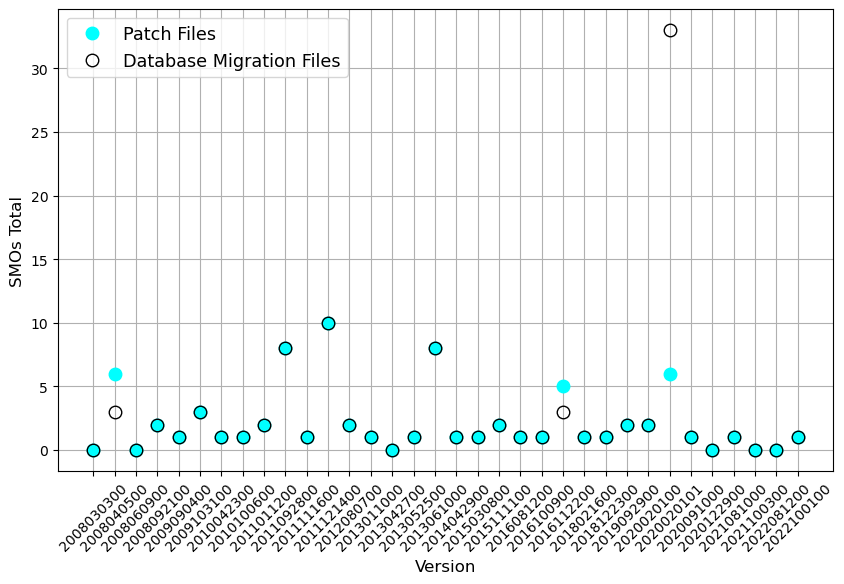

In [61]:
# Plot of Patch files and Database Migration files each version in the dataset
Roundcube_Version = Roundcube_Patch_SMO['Version'].str.replace('upgrade', '') 
Roundcube_SMOs_Total = Roundcube_Patch_SMO['SMOs_Total_RTC']

plt.figure(figsize=(10, 6))  
plt.plot(Roundcube_Version, Roundcube_SMOs_Total, marker='o', color='#00FFFF', label='Patch Files', linestyle='', markersize=9)
DMF_index = Roundcube_DMF_SMO.index
DMF_SMOs_total = Roundcube_DMF_SMO.values
plt.plot(DMF_index, DMF_SMOs_total, marker='o', color='black', label="Database Migration Files", linestyle='', markersize=9, markerfacecolor='none', markeredgecolor='black')
plt.xlabel('Version', fontsize=12)
plt.ylabel("SMOs Total", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(fontsize=12.7)

plt.show()

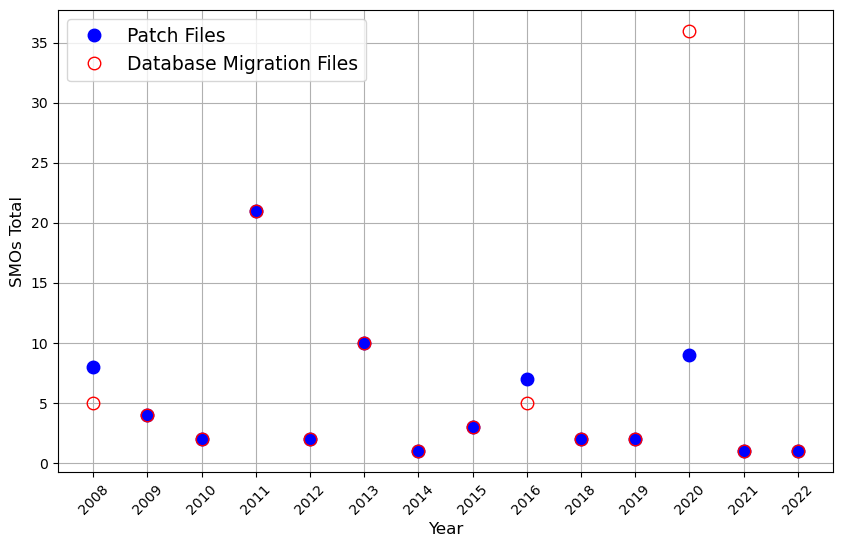

In [62]:
# Year-wise sum of SMOs

Version_Patch = Roundcube_SMO_Merge['Version']
SMOs_Total_Patch = Roundcube_SMO_Merge['SMOs_Total_RTC']
SMOs_Total_DMF = Roundcube_SMO_Merge["SMO's_Total"]
Roundcube_SMO_Merge['Year'] = Roundcube_SMO_Merge['Version'].str[:4]
grouped_data = Roundcube_SMO_Merge.groupby('Year').sum()
Version = grouped_data.index
SMOs_Total_Patch = grouped_data['SMOs_Total_RTC']
SMOs_Total_DMF = grouped_data["SMO's_Total"]

plt.figure(figsize=(10, 6))  
plt.plot(Version, SMOs_Total_Patch, marker='o', color='b', label='Patch Files', linestyle='', markersize=9)
plt.plot(Version, SMOs_Total_DMF, marker='o', color='r', label='Database Migration Files', linestyle='', markersize=9, markerfacecolor='none', markeredgecolor='r')
plt.xlabel('Year', fontsize=12)
plt.ylabel('SMOs Total', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(fontsize=13.5)

plt.show()

In [63]:
# Concatenate the two DataFrames, Extract the required columns for the table level and column level.
Roundcube_Patch_df = Roundcube_Merged[['Version', 'Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column', "SMOs_Total"]]
Roundcube_DMF_df = Roundcube_DMF_df[['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num']].reset_index(drop=True)

Roundcube_Patch_DMF_df = pd.concat([Roundcube_Patch_df, Roundcube_DMF_df], axis=1)
Roundcube_Table_df = Roundcube_Patch_DMF_df[['Version', 'Create_Table', 'Rename_Table', 'CT num','Drop_Table','Rename_Table','DT num']]
Roundcube_Column_df= Roundcube_Patch_DMF_df[['Version', 'Add_Column', 'Rename_Column','AC num', 'Drop_Column', 'Rename_Column','DC num', 'Change_Column_Datatype', 'CC num']]

In [64]:
# Table level smos
Roundcube_Table_df

,Version,Create_Table,Rename_Table,CT num,Drop_Table,Rename_Table,DT num
0,2008030300,0,0,0,0,0,0
1,2008040500,0,0,0,0,0,0
2,2008060900,0,0,0,0,0,0
3,2008092100,0,0,0,0,0,0
4,2009090400,0,0,0,0,0,0
5,2009103100,2,0,2,0,0,0
6,2010042300,0,0,0,0,0,0
7,2010100600,0,0,0,0,0,0
8,2011011200,0,0,0,0,0,0
9,2011092800,5,0,5,1,0,1


In [65]:
# Column level smos
Roundcube_Column_df

,Version,Add_Column,Rename_Column,AC num,Drop_Column,Rename_Column,DC num,Change_Column_Datatype,CC num
0,2008030300,0,0,0,0,0,0,0,0
1,2008040500,0,0,0,0,0,0,6,3
2,2008060900,0,0,0,0,0,0,0,0
3,2008092100,0,0,0,1,0,1,1,1
4,2009090400,0,0,0,0,0,0,1,1
5,2009103100,1,0,1,0,0,0,0,0
6,2010042300,0,0,0,0,0,0,1,1
7,2010100600,0,0,0,0,0,0,1,1
8,2011011200,1,0,1,0,0,0,1,1
9,2011092800,0,0,0,0,0,0,2,2


In [66]:
# Extract table count and table names from database migration files.

os.chdir('..')
MigrationFiles_Path = "{}/Datasets/Roundcube/Input/Migration_Files".format(os.getcwd())

File_Names = []
Table_Counts = []
Table_Names = []

for Filename in os.listdir(MigrationFiles_Path):
    if Filename.endswith('.sql'):
        File_Path = os.path.join(MigrationFiles_Path, Filename)

        with open(File_Path, 'r') as File:
            Content = File.read()
            
        DDL_Statements = Content.split(';')
        Count = 0
        Names = []

        for Statement in DDL_Statements:
            if 'CREATE TABLE' in Statement:
                Table_Name = Statement.split('CREATE TABLE')[1].split('(')[0].strip()
                Names.append(Table_Name)
                Count += 1

        File_Names.append(Filename)
        Table_Counts.append(Count)
        Table_Names.append(Names)


Column_Names = {'File Name': File_Names, 'Table_Count': Table_Counts, 'Table_Names': Table_Names}
Roundcube_Table_list_df = pd.DataFrame(Column_Names)
print(Roundcube_Table_list_df)

Roundcube_Table_Filename = "{}/Datasets/Roundcube/Output/Roundcube_Databseschemafiles_table_list.csv".format(os.getcwd())
Roundcube_Table_list_df.to_csv(Roundcube_Table_Filename, index=False)
print("Roundcube Table List saved to: {}".format(Roundcube_Table_Filename))
os.chdir('Code')

                            File Name  Table_Count  \
0   Roundcube_2007101000_mod_sort.sql            6   
1   Roundcube_2008030300_mod_sort.sql            6   
2   Roundcube_2008040500_mod_sort.sql            6   
3   Roundcube_2008060900_mod_sort.sql            6   
4   Roundcube_2008092100_mod_sort.sql            6   
5   Roundcube_2009090400_mod_sort.sql            6   
6   Roundcube_2009103100_mod_sort.sql            8   
7   Roundcube_2010042300_mod_sort.sql            8   
8   Roundcube_2010100600_mod_sort.sql            8   
9   Roundcube_2011011200_mod_sort.sql            8   
10  Roundcube_2011092800_mod_sort.sql           12   
11  Roundcube_2011111600_mod_sort.sql           12   
12  Roundcube_2011121400_mod_sort.sql           12   
13  Roundcube_2012080700_mod_sort.sql           12   
14  Roundcube_2013011000_mod_sort.sql           13   
15  Roundcube_2013042700_mod_sort.sql           13   
16  Roundcube_2013052500_mod_sort.sql           14   
17  Roundcube_2013061000_mod

In [67]:
# Calculate the total number of tables increased in Roundcube
Roundcube_Total_Tables_Increased =  Roundcube_Table_list_df.iloc[-1]['Table_Count'] - Roundcube_Table_list_df.iloc[0]['Table_Count']
print("Total number of tables increased in Roundcube: {}".format(Roundcube_Total_Tables_Increased))

Total number of tables increased in Roundcube: 12


In [68]:
#Calculate absolute and percentage values for each metric across the three datasets

Weberp_Patch_abs_per_df = Weberp_Patch_Percent_df
Joomla_Patch_abs_per_df = Joomla_Patch_Percent_df
Roundcube_Patch_abs_per_df = Roundcube_Patch_Percent_df

Weberp_Patch_abs_per_df = Weberp_Patch_abs_per_df.drop(['Commit_Count', 'SMOs_Total'], errors='ignore')
Joomla_Patch_abs_per_df = Joomla_Patch_abs_per_df.drop(['Commit_Count', 'SMOs_Total'], errors='ignore')
Roundcube_Patch_abs_per_df = Roundcube_Patch_abs_per_df.drop(['Commit_Count', 'SMOs_Total'], errors='ignore')


All_Projects_df = pd.DataFrame({
    'WebERP': Weberp_Patch_abs_per_df,
    'Joomla': Joomla_Patch_abs_per_df,
    'RoundCube': Roundcube_Patch_abs_per_df
})


All_Projects_df = All_Projects_df.transpose()
Column_order = ['Create_Table', 'Percent_create', 'Drop_Table', 'Percent_drop', 'Add_Column', 'Percent_add',
                'Drop_Column', 'Percent_dc', 'Change_Column_Datatype', 'Percent_ccd', 'Rename_Table',
                'Percent_rt', 'Rename_Column', 'Percent_rc']

All_Projects_df = All_Projects_df[Column_order]

All_Projects_df = All_Projects_df.rename(columns={
    'Create_Table': 'CT',
    'Percent_create': 'CT%',
    'Drop_Table': 'DT',
    'Percent_drop': 'DT%',
    'Add_Column': 'AC',
    'Percent_add': 'AC%',
    'Drop_Column': 'DC',
    'Percent_dc': 'DC%',
    'Change_Column_Datatype': 'CCD',
    'Percent_ccd': 'CCD%',
    'Rename_Table': 'RT',
    'Percent_rt': 'RT%',
    'Rename_Column': 'RC',
    'Percent_rc': 'RC%'
})


All_Projects_Abs_Per = tabulate(All_Projects_df, headers='keys', tablefmt='pretty', showindex=True, floatfmt=(".1f", ".1f", ".1f", ".1f"))
print(All_Projects_Abs_Per)

+-----------+------+------+------+------+-------+------+------+-----+-------+------+-----+-----+------+-----+
|           |  CT  | CT%  |  DT  | DT%  |  AC   | AC%  |  DC  | DC% |  CCD  | CCD% | RT  | RT% |  RC  | RC% |
+-----------+------+------+------+------+-------+------+------+-----+-------+------+-----+-----+------+-----+
|  WebERP   | 92.0 | 19.1 | 5.0  | 1.0  | 187.0 | 38.9 | 19.0 | 4.0 | 162.0 | 33.7 | 1.0 | 0.2 | 15.0 | 3.1 |
|  Joomla   | 13.0 | 7.6  | 19.0 | 11.1 | 10.0  | 5.8  | 5.0  | 2.9 | 122.0 | 71.3 | 1.0 | 0.6 | 1.0  | 0.6 |
| RoundCube | 15.0 | 20.5 | 3.0  | 4.1  | 11.0  | 15.1 | 7.0  | 9.6 | 37.0  | 50.7 | 0.0 | 0.0 | 0.0  | 0.0 |
+-----------+------+------+------+------+-------+------+------+-----+-------+------+-----+-----+------+-----+


In [69]:
#Calculate the Total row: absolute and percentage values for each metric across the three datasets

Weberp_Patch_total_df = Weberp_Patch_Percent_df
Joomla_Patch_total_df = Joomla_Patch_Percent_df
Roundcube_Patch_total_df = Roundcube_Patch_Percent_df

Weberp_Patch_total_df = Weberp_Patch_total_df.drop(['Commit_Count'], errors='ignore')
Joomla_Patch_total_df = Joomla_Patch_total_df.drop(['Commit_Count'], errors='ignore')
Roundcube_Patch_total_df = Roundcube_Patch_total_df.drop(['Commit_Count'], errors='ignore')

# total SMOs for each project
Sum_smo = Roundcube_Patch_total_df['SMOs_Total'] + Joomla_Patch_total_df['SMOs_Total'] + Weberp_Patch_total_df['SMOs_Total']

# Calculate the total row 
Sum_ct = Roundcube_Patch_total_df['Create_Table'] + Joomla_Patch_total_df['Create_Table'] + Weberp_Patch_total_df['Create_Table']
Sum_dt = Roundcube_Patch_total_df['Drop_Table'] + Joomla_Patch_total_df['Drop_Table'] + Weberp_Patch_total_df['Drop_Table']
Sum_ac = Roundcube_Patch_total_df['Add_Column'] + Joomla_Patch_total_df['Add_Column'] + Weberp_Patch_total_df['Add_Column']
Sum_dc = Roundcube_Patch_total_df['Drop_Column'] + Joomla_Patch_total_df['Drop_Column'] + Weberp_Patch_total_df['Drop_Column']
Sum_ccd = Roundcube_Patch_total_df['Change_Column_Datatype'] + Joomla_Patch_total_df['Change_Column_Datatype'] + Weberp_Patch_total_df['Change_Column_Datatype']
Sum_rt = Roundcube_Patch_total_df['Rename_Table'] + Joomla_Patch_total_df['Rename_Table'] + Weberp_Patch_total_df['Rename_Table']
Sum_rc = Roundcube_Patch_total_df['Rename_Column'] + Joomla_Patch_total_df['Rename_Column'] + Weberp_Patch_total_df['Rename_Column']

Combined_Projects_df = pd.DataFrame({
    'CT': Sum_ct,
    'DT': Sum_dt,
    'AC': Sum_ac,
    'DC': Sum_dc,
    'CCD': Sum_ccd,
    'RT': Sum_rt,
    'RC': Sum_rc,
    'CT%': round((Sum_ct / Sum_smo) * 100, 1),
    'DT%': round((Sum_dt / Sum_smo) * 100, 1),
    'AC%': round((Sum_ac / Sum_smo) * 100, 1),
    'DC%': round((Sum_dc / Sum_smo) * 100, 1),
    'CCD%': round((Sum_ccd / Sum_smo) * 100, 1),
    'RT%': round((Sum_rt / Sum_smo) * 100, 1),
    'RC%': round((Sum_rc / Sum_smo) * 100, 1),
}, index=['Total'])


Total_all_Projects = tabulate(Combined_Projects_df, headers='keys', tablefmt='pretty', showindex=True, floatfmt=(".1f", ".1f", ".1f", ".1f"))
print(Total_all_Projects)

+-------+-------+------+-------+------+-------+-----+------+------+-----+------+-----+------+-----+-----+
|       |  CT   |  DT  |  AC   |  DC  |  CCD  | RT  |  RC  | CT%  | DT% | AC%  | DC% | CCD% | RT% | RC% |
+-------+-------+------+-------+------+-------+-----+------+------+-----+------+-----+------+-----+-----+
| Total | 120.0 | 27.0 | 208.0 | 31.0 | 321.0 | 2.0 | 16.0 | 16.6 | 3.7 | 28.7 | 4.3 | 44.3 | 0.3 | 2.2 |
+-------+-------+------+-------+------+-------+-----+------+------+-----+------+-----+------+-----+-----+
